# Perfil Geotérmico y Habitabilidad Subsuperficial: Análisis de la Tierra

---

## Descripción del Proyecto

Este notebook presenta un **modelo de conducción térmica 1D** para calcular el perfil geotérmico de la corteza planetaria, con énfasis en la identificación de la **zona de habitabilidad subsuperficial** donde el agua puede existir en estado líquido bajo la superficie.

### 🎯 Objetivos

1. **Calcular perfiles geotérmicos** T(z), P(z), ρ(z) para los primeros 10-300 km de profundidad
2. **Identificar la zona de aguabilidad** donde existe agua líquida termodinámica (criterios IAPWS)
3. **Determinar la zona habitable** aplicando límites biológicos de extremófilos conocidos
4. **Explorar escenarios planetarios** variando distancia orbital, masa, radio y flujo de calor
5. **Validar resultados** contra observaciones terrestres de vida subsuperficial

---

## 📋 Modelo Físico

### Ecuación de Conducción Térmica (Estado Estacionario)

$$\frac{d}{dz}\left[\lambda(z,T,P) \frac{dT}{dz}\right] + A(z) = 0$$

**Componentes del modelo**:

- **$\lambda(z,T,P)$**: Conductividad térmica dependiente de:
  - Composición mineralógica (usando BurnMan)
  - Temperatura (componentes fonónico y radiativo)
  - Presión (vía densidad y propiedades termodinámicas)

- **$A(z) = A_0 \exp(-z/h_r)$**: Producción radiactiva exponencial
  - Modelo de Hasterok & Chapman (2011)
  - $A_0 = 2.5$ μW/m³ (superficie continental típica)
  - $h_r = 10$ km (profundidad característica)

### Parámetros de Referencia (Tierra Continental)

| Parámetro | Valor | Unidad |
|-----------|-------|--------|
| Flujo de calor superficial | 65 | mW/m² |
| Temperatura superficial | 288 | K (15°C) |
| Producción radiactiva superficial | 2.5 | μW/m³ |
| Profundidad característica | 10 | km |
| Fronteras de capas (corteza) | [16, 23, 39] | km |

---

## 🌊 Zonas de Habitabilidad

### 1. Zona de Aguabilidad (Water Stability Zone)
Región termodinámica donde el agua es líquida:
- **Criterio inferior**: $T > T_{\text{fusión}}(P)$ (curva IAPWS R14-08)
- **Criterio superior**: $T < T_{\text{ebullición}}(P)$ (curva IAPWS-95)

### 2. Zona Habitable (Habitable Zone)
Subconjunto con límites biológicos de extremófilos:
- **Límite térmico**: $T < 394$ K (121°C, *Geogemma barossii*)
- **Límite de presión**: $P < 110$ MPa (1100 bar, *Shewanella benthica*)

---

## 📊 Estructura del Notebook

1. **Configuración inicial**: Librerías, constantes y funciones auxiliares
2. **Preparación del modelo**: Composiciones minerales y conductividad térmica (VRH)
3. **Cálculo del perfil geotérmico**: Modelo de conducción 1D con BurnMan
4. **Análisis de habitabilidad**: Identificación de zonas usando IAPWS
5. **Escenarios planetarios**: Tierra a diferentes distancias orbitales (1.0 UA, 1.52 UA)
6. **Análisis paramétrico**: Widgets interactivos y estudios de sensibilidad

---

## 📚 Referencias Principales

- **Hasterok & Chapman (2011)**: Modelo de producción radiactiva exponencial
- **IAPWS R14-08 (2011)**: Curvas de fusión del hielo
- **IAPWS-95**: Ecuación de estado del agua (ebullición)
- **Kopparapu et al. (2013)**: Zona habitable circunestelar
- **Onstott et al. (2006)**: Vida subsuperficial profunda

---

## 📑 Índice de Contenidos

1. **[Configuración Inicial](#1-configuración-inicial)**
   - Importar librerías
   - Definir constantes físicas
   - Definir funciones auxiliares (temperatura, IAPWS, habitabilidad, visualización)

2. **[Preparación del Modelo](#2-preparación-del-modelo-de-conductividad-térmica)**
   - Composiciones minerales por capa
   - Modelo de conductividad térmica VRH

3. **[Cálculo del Perfil Geotérmico](#3-cálculo-del-perfil-geotérmico)**
   - Ejecutar modelo de conducción térmica 1D
   - Visualización de perfiles (T, P, ρ, q, A, dT/dz)

4. **[Análisis de Habitabilidad](#4-análisis-de-habitabilidad-subsuperficial)**
   - Marco teórico: aguabilidad vs habitabilidad
   - Modelo termodinámico IAPWS
   - Límites biológicos de extremófilos
   - Aplicación a la Tierra (1.0 AU)
   - Visualización de diagramas P-T

5. **[Escenarios Planetarios](#5-escenarios-planetarios-efecto-de-la-distancia-orbital)**
   - Tierra a 1.52 UA (órbita de Marte)
   - Comparación entre escenarios

6. **[Análisis Paramétrico Interactivo](#6-análisis-paramétrico-interactivo)**
   - Explorador de habitabilidad planetaria (widget)
   - Análisis de sensibilidad: zona habitable vs distancia orbital

7. **[Conclusiones y Aplicaciones](#7-conclusiones-y-aplicaciones)**
   - Resultados principales
   - Aplicaciones astrobiológicas
   - Mejoras futuras

---

---

## 1. Configuración Inicial

### Importar Librerías

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import geotherm_calculator as gc

from astropy import constants as const
from scipy.optimize import brentq

from ipywidgets import interact, widgets

from matplotlib.patches import Patch


# Librería IAPWS para propiedades del agua
from iapws import IAPWS95
from iapws.iapws08 import _Tf, _Tb, _Triple
from iapws._iapws import _Sublimation_Pressure, _Melting_Pressure

### Definir Constantes Físicas y Parámetros Terrestres

In [2]:
G = const.G.value
R_gas = const.R.value
GPa = 1e9 #Pa
km = 1000 #m
mWm2 = 1e-3 #w/m2
den = 1000/100**3 #g/cm^-3
deg = 180/np.pi
rad = 1/deg

#Tierra
Me = const.M_earth.value
Re = const.R_earth.value
R_core = 0.55*Re
Tsurface = 298.0 

P_surf = 1e5     # Pa


### Definir Funciones Auxiliares

Las siguientes funciones implementan:

1. **`T_eq()`**: Cálculo de temperatura de equilibrio planetario basado en balance radiativo
2. **`T_melting_IAPWS()`**: Temperatura de fusión del hielo usando estándar IAPWS R14-08
3. **`T_boiling_IAPWS()`**: Temperatura de saturación (ebullición) usando IAPWS-95
4. **`find_liquid_zone()`**: Identifica zona de agua líquida (aguabilidad)
5. **`find_habitable_zone()`**: Identifica zona habitable dentro de la zona de aguabilidad
6. **`liq_hab_zone_data()`**: Resume información de zonas encontradas
7. **`Graficos()`**: Visualización P-T, P-depth, T-depth con zonas marcadas

In [3]:
def T_eq(
    distance_AU,
    L_star=1.0,
    albedo=0.30,
    tau=0.21
):
    T_eq = 331.0 * ( (L_star*(1-albedo))/((1 + tau) * distance_AU**2) )**0.25
    return T_eq

# =============================================================================
# FUNCIONES PARA ANÁLISIS DE HABITABILIDAD CON IAPWS
# ===================================================================   ==========

def T_melting_IAPWS(P, ice_type='Ih', salinity=0.0):
    """
    Temperatura de fusión del hielo usando IAPWS estándar.
    
    Parameters
    ----------
    P : float or array
        Presión [Pa]
    ice_type : str
        Tipo de hielo: 'Ih', 'III', 'V', 'VI', 'VII'
        Default: 'Ih' (válido 0-209 MPa)
    salinity : float
        Salinidad [kg_salt/kg_water]
        Default: 0.0 (agua pura)
    
    Returns
    -------
    float or array
        Temperatura de fusión [K]
    
    Notes
    -----
    Usa IAPWS R14-08(2011) para agua pura.
    Usa IAPWS-08 Seawater para agua con salinidad.
    
    Rangos de validez por polimorfo:
    - Ih:  0 - 209.9 MPa
    - III: 209.9 - 350.1 MPa  
    - V:   350.1 - 632.4 MPa
    - VI:  632.4 - 2216 MPa
    - VII: > 2216 MPa
    """
    P_MPa = np.atleast_1d(P) / 1e6  # Convertir a MPa
    T_melt = np.zeros_like(P_MPa)
    
    if salinity > 0:
        # Usar IAPWS-08 para agua salada
        for i, p in enumerate(P_MPa):
            try:
                T_melt[i] = _Tf(p, salinity)
            except:
                # Si falla, usar agua pura como fallback
                T_melt[i] = _Melting_Pressure_inverse(p, ice_type)
    else:
        # Agua pura: usar IAPWS R14-08
        for i, p in enumerate(P_MPa):
            try:
                T_melt[i] = _Melting_Pressure_inverse(p, ice_type)
            except:
                T_melt[i] = np.nan
    
    return T_melt[0] if np.isscalar(P) else T_melt


def _Melting_Pressure_inverse(P_MPa, ice='Ih'):
    """
    Inversa numérica de _Melting_Pressure para obtener T dado P.
    """
    
    # Rangos de temperatura por polimorfo
    T_ranges = {
        'Ih':  (251.165, 273.16),
        'III': (251.166, 256.164),
        'V':   (256.165, 273.31),
        'VI':  (273.32, 355),
        'VII': (355.1, 715),
    }
    
    T_min, T_max = T_ranges.get(ice, (200, 800))
    
    try:
        T_melt = brentq(lambda T: _Melting_Pressure(T, ice=ice) - P_MPa, 
                        T_min, T_max, xtol=1e-6)
        return T_melt
    except:
        return np.nan


def T_boiling_IAPWS(P, salinity=0.0):
    """
    Temperatura de saturación (ebullición) usando IAPWS-95.
    
    Parameters
    ----------
    P : float or array
        Presión [Pa]
    salinity : float
        Salinidad [kg_salt/kg_water]
        Default: 0.0 (agua pura)
    
    Returns
    -------
    float or array
        Temperatura de saturación [K]
    
    Notes
    -----
    Válido desde punto triple (611.657 Pa) hasta punto crítico (22.064 MPa).
    Por encima del punto crítico, el agua está en estado supercrítico.
    
    Para agua salada, usa IAPWS-08 Seawater.
    """
    P_array = np.atleast_1d(P)
    T_sat = np.zeros_like(P_array)
    
    # Límites de IAPWS-95
    P_triple = 611.657  # Pa
    P_crit = 22.064e6   # Pa
    T_crit = 647.096    # K
    
    if salinity > 0:
        # Usar IAPWS-08 para agua salada
        for i, p in enumerate(P_array):
            try:
                T_sat[i] = _Tb(p / 1e6, salinity)  # _Tb espera MPa
            except:
                # Fallback: agua pura
                if P_triple <= p <= P_crit:
                    T_sat[i] = IAPWS95(P=p/1e6, x=0).T  # Línea de saturación
                elif p > P_crit:
                    T_sat[i] = T_crit  # Supercrítico
                else:
                    T_sat[i] = np.nan
    else:
        # Agua pura: usar IAPWS95 directamente
        for i, p in enumerate(P_array):
            if P_triple <= p <= P_crit:
                try:
                    T_sat[i] = IAPWS95(P=p/1e6, x=0).T  # x=0 = líquido saturado
                except:
                    T_sat[i] = np.nan
            elif p > P_crit:
                T_sat[i] = T_crit  # Por encima del punto crítico
            else:
                T_sat[i] = np.nan
    
    return T_sat[0] if np.isscalar(P) else T_sat


def find_liquid_zone(df_geotherm, salinity=0.0, ice_type='Ih', information=True):
    """
    Identifica zona de agua líquida usando IAPWS estándar internacional.
    
    Parameters
    ----------
    df_geotherm : pd.DataFrame
        Perfil geotérmico con columnas: depth_m, T_K, P_Pa
    salinity : float
        Salinidad del agua [kg_salt/kg_water]
        Default: 0.0 (agua pura)
    ice_type : str
        Polimorfo de hielo para presiones altas
        Default: 'Ih' (suficiente para corteza terrestre)
    
    Returns
    -------
    dict
        Diccionario con información completa de aguabilidad:
        
        - has_liquid_water: bool, True si existe agua líquida
        - z_water_top_km, z_water_bottom_km: límites de profundidad [km]
        - water_thickness_km: espesor de la capa de agua líquida [km]
        - T_water_top_C, T_water_bottom_C: temperaturas en límites [°C]
        - P_water_top_MPa, P_water_bottom_MPa: presiones en límites [MPa]
        - water_indices: índices donde existe agua líquida
        
        - T_melt, T_boil: curvas de fusión y ebullición [K]
        - salinity, ice_type: parámetros usados
    """
    z = df_geotherm['depth_m'].values
    T = df_geotherm['T_K'].values
    P = df_geotherm['P_Pa'].values
    
    # Calcular límites de fase con IAPWS
    T_melt = T_melting_IAPWS(P, ice_type=ice_type, salinity=salinity)
    T_boil = T_boiling_IAPWS(P, salinity=salinity)
    
    # Zona donde el agua es líquida (AGUABILIDAD)
    liquid_mask = (T > T_melt) & (T < T_boil) & ~np.isnan(T_melt) & ~np.isnan(T_boil)
    
    liquid_indices = np.where(liquid_mask)[0]
    has_liquid_water = len(liquid_indices) > 0
    
    if has_liquid_water:
        liquid_zone = z[liquid_indices]
        T_liquid = T[liquid_indices]
        P_liquid = P[liquid_indices]
        return {
            'liquid_zone' : liquid_zone,
            'T_liquid' : T_liquid,
            'P_liquid' : P_liquid,
            'T_melt' : T_melt,
            'T_boil' : T_boil,
        }
    
    else: 
        if information:
            print("No se encontró zona de agua líquida.")

        liquid_zone = None
        T_liquid = None
        P_liquid = None
        return {
            'liquid_zone' : liquid_zone,
            'T_liquid' : T_liquid,
            'P_liquid' : P_liquid,
            'T_melt' : T_melt,
            'T_boil' : T_boil,
        }



def find_habitable_zone(liquid_zone, df_geotherm, T_bio_max=394.0, P_bio_max=110e6, information=True):
    """
    Identifica zona habitable dentro de una zona de agua líquida.
    
    Parameters
    ----------
    liquid_zone : array
        Profundidades [m] donde existe agua líquida
    df_geotherm : pd.DataFrame
        Perfil geotérmico con columnas: depth_m, T_K, P_Pa
    T_bio_max : float
        Temperatura máxima biológica [K]
        Default: 394 K (121°C, Geogemma barossii)
    P_bio_max : float
        Presión máxima biológica [Pa]
        Default: 110e6 Pa (110 MPa, ~1100 bar)
    
    Returns
    -------
    dict
        Diccionario con información completa de habitabilidad:
        
        - has_habitable_zone: bool, True si existe zona habitable
        - z_top_km, z_bottom_km: límites de profundidad [km] (NaN si no existe)
        - thickness_km: espesor de la capa [km] (NaN si no existe)
        - T_top_C, T_bottom_C: temperaturas en límites [°C] (NaN si no existe)
        - P_top_MPa, P_bottom_MPa: presiones en límites [MPa] (NaN si no existe)
        - indices: índices del array donde existe zona habitable (None si no existe)
    """
    z = df_geotherm['depth_m'].values
    T = df_geotherm['T_K'].values
    P = df_geotherm['P_Pa'].values
    
    # Máscara para zona habitable dentro de la zona líquida
    bio_mask = np.isin(z, liquid_zone) & (T < T_bio_max) & (P < P_bio_max)
    
    # Información de la zona habitable
    has_habitable_zone = bio_mask.any()
    indices = np.where(bio_mask)[0]

    if has_habitable_zone:
        habitable_zone = z[indices]
        T_habitable = T[indices]
        P_habitable = P[indices]
        return {
            'habitable_zone' : habitable_zone,
            'T_habitable' : T_habitable,    
            'P_habitable' : P_habitable,
        }
    else:
        if information:
            print("No se encontró zona habitable.")
        habitable_zone = None
        T_habitable = None
        P_habitable = None
        return {
            'habitable_zone' : habitable_zone,
            'T_habitable' : T_habitable,
            'P_habitable' : P_habitable,
        }

def liq_hab_zone_data(liquid_zone_data, habitable_zone_data):
    if liquid_zone_data['liquid_zone'] is not None:
        liq_top = liquid_zone_data['liquid_zone'][0]
        liq_bot = liquid_zone_data['liquid_zone'][-1]

        if habitable_zone_data['habitable_zone'] is not None:
            bio_top = habitable_zone_data['habitable_zone'][0]
            bio_bot = habitable_zone_data['habitable_zone'][-1]
            
        # Resumen de Zona de Aguabilidad
        print(f"\n💧 ZONA DE AGUABILIDAD (Agua Líquida):")
        print(f"   Profundidad: {liquid_zone_data['liquid_zone'][0]:.2f} - {liquid_zone_data['liquid_zone'][-1]:.2f} km")
        print(f"   Temperatura: {liquid_zone_data['T_liquid'][0]:.2f} - {liquid_zone_data['T_liquid'][-1]:.2f} K")
        print(f"   Presión: {liquid_zone_data['P_liquid'][0]/1e6:.2f} - {liquid_zone_data['P_liquid'][-1]/1e6:.2f} MPa")
        print(f"   Espesor: {(liq_bot - liq_top)/1000:.3f} km")


        # Resumen de Zona Habitable
        if habitable_zone_data['habitable_zone'] is not None:
            bio_top = habitable_zone_data['habitable_zone'][0]
            bio_bot = habitable_zone_data['habitable_zone'][-1]

            print(f"\n🦠 ZONA HABITABLE (Límites Biológicos):")
            print(f"   Profundidad: {habitable_zone_data['habitable_zone'][0]:.2f} - {habitable_zone_data['habitable_zone'][-1]:.2f} km")
            print(f"   Temperatura: {habitable_zone_data['T_habitable'][0]:.2f} - {habitable_zone_data['T_habitable'][-1]:.2f} K ({habitable_zone_data['T_habitable'][0]-273.15:.1f} - {habitable_zone_data['T_habitable'][-1]-273.15:.1f}°C)")
            print(f"   Presión: {habitable_zone_data['P_habitable'][0]/1e6:.2f} - {habitable_zone_data['P_habitable'][-1]/1e6:.2f} MPa")
            print(f"   Espesor: {(bio_bot - bio_top)/1000:.3f} km")
           

            # Porcentaje de zona habitable respecto a zona de aguabilidad
            frac_habitable = ((bio_bot - bio_top) / (liq_bot - liq_top)) * 100
            print(f"\n📊 Zona Habitable = {frac_habitable:.1f}% de la Zona de Aguabilidad")
        else:
            print(f"\n🦠 ZONA HABITABLE: No existe")

    else:
        print("No se encontró zona de agua líquida.")
        
    print("\n" + "=" * 80)

def Graficos(df_geotherm, liquid_zone_data, habitable_zone_data):
    
# =============================================================================
# GRÁFICOS P-T, P-depth y T-depth CON ZONAS DE HABITABILIDAD
# =============================================================================

    fig = plt.figure(figsize=(25, 10))
    gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])  # Diagrama P-T
    ax2 = fig.add_subplot(gs[0, 1])  # P-depth
    ax3 = fig.add_subplot(gs[0, 2])  # T-depth

    # Extraer datos
    z = df_geotherm['depth_km'].values
    T = df_geotherm['T_K'].values
    P = df_geotherm['P_Pa'].values / 1e6  # Convertir a MPa

    # Datos de zonas (de cálculos anteriores)
    z_water = liquid_zone_data['liquid_zone'] / 1000  # km
    T_water = liquid_zone_data['T_liquid']  # K
    P_water = liquid_zone_data['P_liquid'] / 1e6  # MPa

    z_hab = habitable_zone_data['habitable_zone'] / 1000  # km
    T_hab = habitable_zone_data['T_habitable']  # K
    P_hab = habitable_zone_data['P_habitable'] / 1e6  # MPa

    # Extract only the values corresponding to the liquid water zone
    T_melt = liquid_zone_data['T_melt'] #K
    T_boil = liquid_zone_data['T_boil'] #K
    T_melt_water = T_melt[:len(P_water)]  # Slice to match P_water length
    T_boil_water = T_boil[:len(P_water)]  # Slice to match P_water length

    # Filter out NaN values for valid melting curve
    mask_valid_melt = ~np.isnan(T_melt_water)
    P_melt_valid = P_water[mask_valid_melt]
    T_melt_valid = T_melt_water[mask_valid_melt]

    # Límites biológicos
    T_bio_max = 394.0  # K (121°C)
    P_bio_max = 110.0  # MPa

    # =============================================================================
    # PANEL 1: DIAGRAMA P-T
    # =============================================================================

    # Región de agua líquida (entre fusión y ebullición)
    T_fill = np.concatenate([T_melt_valid, T_boil_water[::-1]])
    P_fill = np.concatenate([P_melt_valid, P_water[::-1]])
    ax1.fill(T_fill, P_fill, color='lightskyblue', alpha=0.4, 
            label='Agua Líquida\n(Termodinámica)', zorder=1)

    # Región habitable (limitada por T_bio y P_bio)
    T_hab_clipped = T_hab[T_hab <= T_bio_max]
    P_hab_clipped = P_hab[:len(T_hab_clipped)]
    # Obtener T_melt para la zona habitable (usar los mismos índices)
    T_melt_hab_clipped = T_melt_valid[:len(T_hab_clipped)]
    T_fill_hab = np.concatenate([T_melt_hab_clipped, T_hab_clipped[::-1]])
    P_fill_hab = np.concatenate([P_hab_clipped, P_hab_clipped[::-1]])
    ax1.fill(T_fill_hab, P_fill_hab, color='lightgreen', alpha=0.5,
            label='Zona Habitable\n(Límites Biológicos)', zorder=2)

    # Curvas de fase
    ax1.plot(T_melt_valid, P_melt_valid, 'b-', linewidth=2.5, 
            label='Fusión (IAPWS)', zorder=3)
    ax1.plot(T_boil_water, P_water, 'r-', linewidth=2.5, 
            label='Ebullición (IAPWS)', zorder=3)

    # Perfil geotérmico
    ax1.plot(T, P, 'k-', linewidth=3, label='Perfil Geotérmico', zorder=4)

    # Límites biológicos
    ax1.axvline(T_bio_max, color='orange', linestyle='--', linewidth=2.5, 
                label=f'$T_{{bio}}$ = {T_bio_max:.0f} K\n(121°C)', zorder=5)
    ax1.axhline(P_bio_max, color='purple', linestyle='--', linewidth=2.5,
                label=f'$P_{{bio}}$ = {P_bio_max:.0f} MPa\n(1100 bar)', zorder=5)

    # Configuración
    ax1.set_xlabel('Temperatura (°K)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Presión (MPa)', fontsize=13, fontweight='bold')
    ax1.set_title('Diagrama P-T\nZonas de Aguabilidad y Habitabilidad', 
                fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=9, framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax1.set_xlim(250, 450)
    ax1.set_ylim(0, 250)

    # =============================================================================
    # PANEL 2: PERFIL P-depth
    # =============================================================================

    # Zona de agua líquida
    ax2.axhspan(z_water[0], z_water[-1], color='lightskyblue', alpha=0.4,
                label='Agua Líquida', zorder=1)

    # Zona habitable
    ax2.axhspan(z_hab[0], z_hab[-1], color='lightgreen', alpha=0.5,
                label='Zona Habitable', zorder=2)

    # Perfil de presión
    ax2.plot(P, z, 'purple', linewidth=3, label='Perfil P(z)', zorder=3)

    # Límite biológico de presión
    ax2.axvline(P_bio_max, color='purple', linestyle='--', linewidth=2.5,
                label=f'$P_{{bio}}$ = {P_bio_max:.0f} MPa', zorder=4)

    # Marcar fronteras
    ax2.axhline(z_hab[0], color='green', linestyle=':', linewidth=2, alpha=0.7)
    ax2.axhline(z_hab[-1], color='red', linestyle=':', linewidth=2, alpha=0.7)

    # Configuración
    ax2.set_xlabel('Presión (MPa)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Profundidad (km)', fontsize=13, fontweight='bold')
    ax2.set_title('Perfil P-depth\nPresión vs Profundidad', 
                fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    ax2.legend(loc='lower right', fontsize=9, framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax2.set_xlim(0, max(P)*1.1)

    # =============================================================================
    # PANEL 3: PERFIL T-depth
    # =============================================================================

    # Zona de agua líquida
    ax3.axhspan(z_water[0], z_water[-1], color='lightskyblue', alpha=0.4,
                label='Agua Líquida', zorder=1)

    # Zona habitable
    ax3.axhspan(z_hab[0], z_hab[-1], color='lightgreen', alpha=0.5,
                label='Zona Habitable', zorder=2)

    # Perfil de temperatura
    ax3.plot(T, z, 'red', linewidth=3, label='Perfil T(z)', zorder=3)

    # Límite biológico de temperatura
    ax3.axvline(T_bio_max, color='orange', linestyle='--', linewidth=2.5,
                label=f'$T_{{bio}}$ = {T_bio_max:.0f} K', zorder=4)

    # Marcar fronteras
    ax3.axhline(z_hab[0], color='green', linestyle=':', linewidth=2, alpha=0.7)
    ax3.axhline(z_hab[-1], color='red', linestyle=':', linewidth=2, alpha=0.7)

    # Configuración
    ax3.set_xlabel('Temperatura (°K)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Profundidad (km)', fontsize=13, fontweight='bold')
    ax3.set_title('Perfil T-depth\nTemperatura vs Profundidad', 
                fontsize=14, fontweight='bold')
    ax3.invert_yaxis()
    ax3.legend(loc='lower right', fontsize=9, framealpha=0.95)
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax3.set_xlim(250, 450)

    plt.tight_layout()
    plt.show()



---

## 2. Preparación del Modelo de Conductividad Térmica

### Cargar Composiciones Minerales por Capa

In [4]:
mineral_objects = gc.get_mineral_objects()
rocks = gc.prepare_rocks_dict(mineral_objects=mineral_objects)
upper = rocks['upper']

---

## 3. Cálculo del Perfil Geotérmico

### Ejecutar Modelo de Conducción Térmica 1D

Parámetros del cálculo:
- **Flujo de calor superficial**: 65 mW/m²
- **Profundidad máxima**: 10 km
- **Resolución espacial**: 100 m (dz)
- **Fronteras de capas**: [16, 23, 39] km (upper/middle/lower crust, Moho)

In [5]:
df_geotherm = gc.calculate_geotherm(
    rocks=rocks,
    q_s=65e-3,           # 65 mW/m²
    z_max=10e3,         # 10 km 
    dz=100.0,           
    R_planet=Re,
    M_total=Me,
    boundaries=[16e3, 23e3, 39e3],
    T_top=Tsurface,
    A_surface=2.5e-6,
    h_r=10e3
)

### Visualización del Perfil Geotérmico Completo

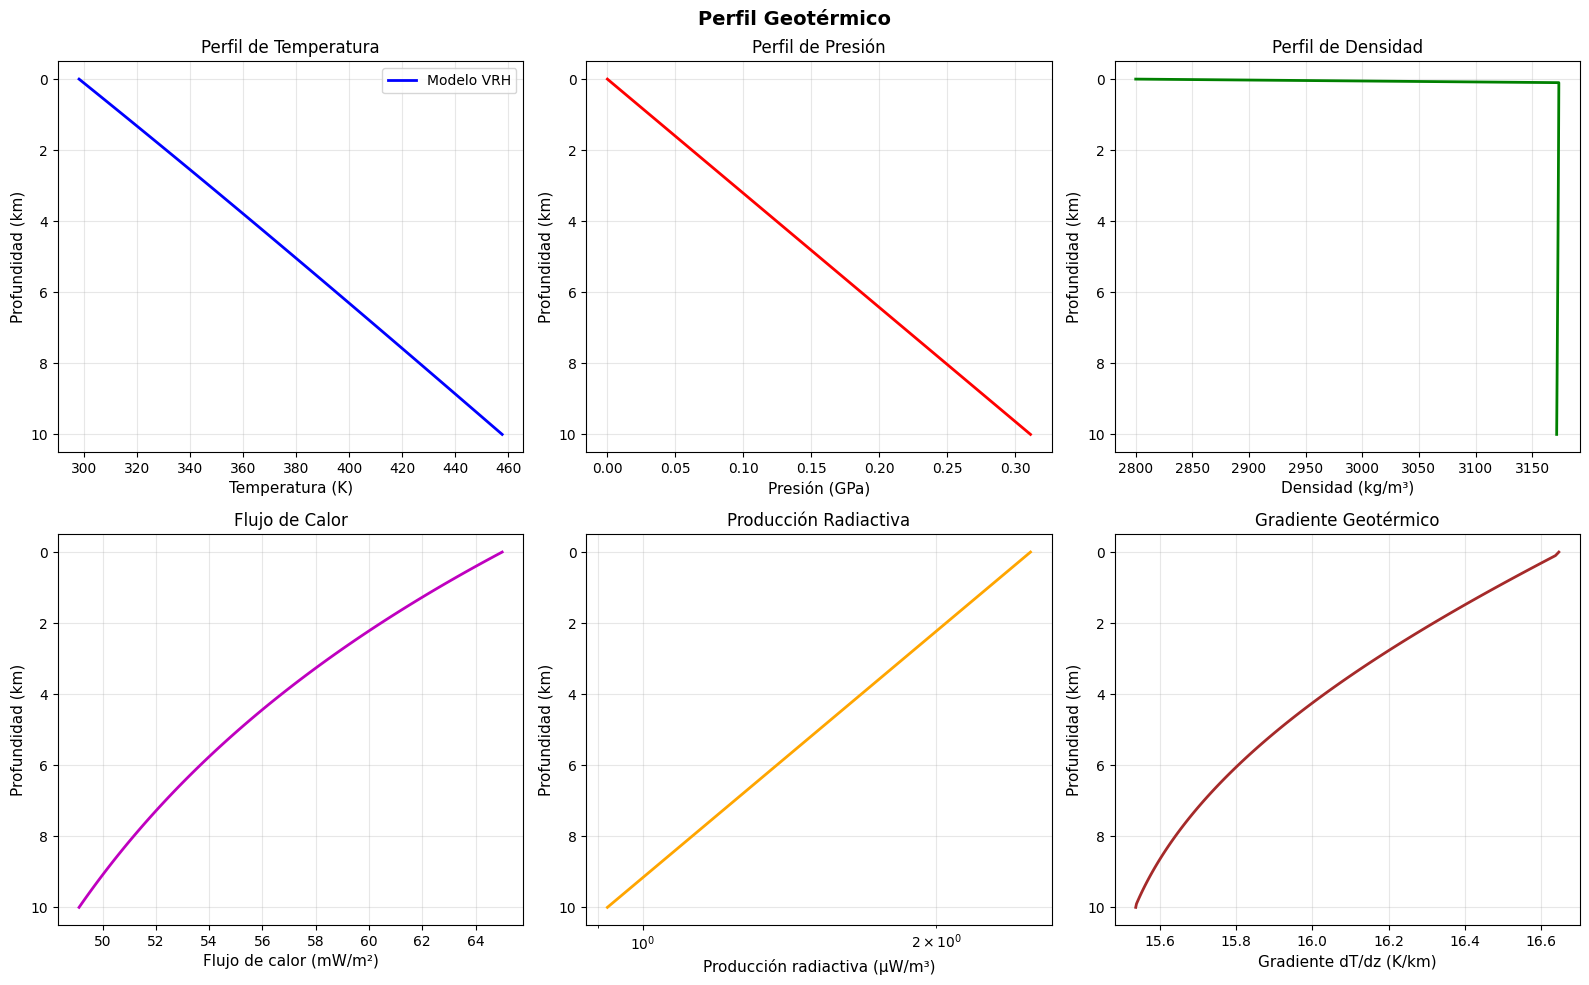

In [6]:

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Perfil Geotérmico', fontsize=14, fontweight='bold')

# 1. Temperatura vs Profundidad
ax1 = axes[0, 0]
ax1.plot(df_geotherm['T_K'], df_geotherm['depth_km'], 'b-', linewidth=2, label='Modelo VRH')
ax1.set_xlabel('Temperatura (K)', fontsize=11)
ax1.set_ylabel('Profundidad (km)', fontsize=11)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_title('Perfil de Temperatura')

# 2. Presión vs Profundidad
ax2 = axes[0, 1]
ax2.plot(df_geotherm['P_Pa'] / 1e9, df_geotherm['depth_km'], 'r-', linewidth=2)
ax2.set_xlabel('Presión (GPa)', fontsize=11)
ax2.set_ylabel('Profundidad (km)', fontsize=11)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)
ax2.set_title('Perfil de Presión')

# 3. Densidad vs Profundidad
ax3 = axes[0, 2]
ax3.plot(df_geotherm['rho_kg_m3'], df_geotherm['depth_km'], 'g-', linewidth=2)
ax3.set_xlabel('Densidad (kg/m³)', fontsize=11)
ax3.set_ylabel('Profundidad (km)', fontsize=11)
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3)
ax3.set_title('Perfil de Densidad')

# 4. Flujo de calor vs Profundidad
ax4 = axes[1, 0]
ax4.plot(df_geotherm['q_W_m2'] * 1000, df_geotherm['depth_km'], 'm-', linewidth=2)
ax4.set_xlabel('Flujo de calor (mW/m²)', fontsize=11)
ax4.set_ylabel('Profundidad (km)', fontsize=11)
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3)
ax4.set_title('Flujo de Calor')

# 5. Producción radiactiva vs Profundidad
ax5 = axes[1, 1]
ax5.plot(df_geotherm['A_uW_m3'], df_geotherm['depth_km'], 'orange', linewidth=2)
ax5.set_xlabel('Producción radiactiva (μW/m³)', fontsize=11)
ax5.set_ylabel('Profundidad (km)', fontsize=11)
ax5.invert_yaxis()
ax5.set_xscale('log')
ax5.grid(True, alpha=0.3, which='both')
ax5.set_title('Producción Radiactiva')

# 6. Gradiente geotérmico vs Profundidad
ax6 = axes[1, 2]
dT_dz = np.gradient(df_geotherm['T_K'].values, df_geotherm['depth_km'].values * 1000)
ax6.plot(dT_dz * 1000, df_geotherm['depth_km'], 'brown', linewidth=2)  # K/km
# Marcar LABs
for T_lab, color, label in [(1350, 'red', 'LAB 1350K'), (1450, 'orange', 'LAB 1450K'), (1573, 'purple', 'LAB 1573K')]:
    idx = np.where(df_geotherm['T_K'].values >= T_lab)[0]
    if len(idx) > 0:
        lab_depth = df_geotherm['depth_km'].iloc[idx[0]]
        ax6.axhline(lab_depth, color=color, linestyle=':', alpha=0.7, linewidth=2)
        ax6.text(ax6.get_xlim()[1]*0.95, lab_depth + 3, f'{label}\n{lab_depth:.0f} km', 
                fontsize=8, ha='right', va='bottom', color=color)
ax6.set_xlabel('Gradiente dT/dz (K/km)', fontsize=11)
ax6.set_ylabel('Profundidad (km)', fontsize=11)
ax6.invert_yaxis()
ax6.grid(True, alpha=0.3)
ax6.set_title('Gradiente Geotérmico')

plt.tight_layout()
plt.show()


In [7]:
# =============================================================================
# RESUMEN DEL PERFIL GEOTÉRMICO CALCULADO
# =============================================================================

print("=" * 80)
print("RESUMEN DEL PERFIL GEOTÉRMICO")
print("=" * 80)

# Información superficial
print(f"\n📍 SUPERFICIE (z = 0 km):")
print(f"   Temperatura: {df_geotherm['T_K'].iloc[0]:.1f} K ({df_geotherm['T_K'].iloc[0]-273.15:.1f}°C)")
print(f"   Presión: {df_geotherm['P_Pa'].iloc[0]/1e6:.3f} MPa")
print(f"   Flujo de calor: {df_geotherm['q_W_m2'].iloc[0]*1000:.1f} mW/m²")
print(f"   Producción radiactiva: {df_geotherm['A_uW_m3'].iloc[0]:.2f} μW/m³")

# Información a 10 km
idx_10km = np.argmin(np.abs(df_geotherm['depth_km'] - 10))
print(f"\n📍 PROFUNDIDAD z = 10 km:")
print(f"   Temperatura: {df_geotherm['T_K'].iloc[idx_10km]:.1f} K ({df_geotherm['T_K'].iloc[idx_10km]-273.15:.1f}°C)")
print(f"   Presión: {df_geotherm['P_Pa'].iloc[idx_10km]/1e6:.2f} MPa")
print(f"   Densidad: {df_geotherm['rho_kg_m3'].iloc[idx_10km]:.0f} kg/m³")
print(f"   Flujo de calor: {df_geotherm['q_W_m2'].iloc[idx_10km]*1000:.1f} mW/m²")

# Gradiente geotérmico superficial
dT_surface = (df_geotherm['T_K'].iloc[10] - df_geotherm['T_K'].iloc[0]) / \
             (df_geotherm['depth_m'].iloc[10] - df_geotherm['depth_m'].iloc[0]) * 1000  # K/km
print(f"\n🌡️  GRADIENTE GEOTÉRMICO SUPERFICIAL (0-1 km): {dT_surface:.1f} K/km")

# Validación con valores terrestres esperados
print(f"\n✅ VALIDACIÓN:")
print(f"   Gradiente superficial esperado: 25-30 K/km (continental)")
if 20 < dT_surface < 35:
    print(f"   ✓ Gradiente calculado ({dT_surface:.1f} K/km) dentro del rango esperado")
else:
    print(f"   ⚠ Gradiente calculado ({dT_surface:.1f} K/km) fuera del rango típico")

print("\n" + "=" * 80)

RESUMEN DEL PERFIL GEOTÉRMICO

📍 SUPERFICIE (z = 0 km):
   Temperatura: 298.0 K (24.9°C)
   Presión: 0.100 MPa
   Flujo de calor: 65.0 mW/m²
   Producción radiactiva: 2.50 μW/m³

📍 PROFUNDIDAD z = 10 km:
   Temperatura: 457.7 K (184.6°C)
   Presión: 311.03 MPa
   Densidad: 3172 kg/m³
   Flujo de calor: 49.1 mW/m²

🌡️  GRADIENTE GEOTÉRMICO SUPERFICIAL (0-1 km): 16.6 K/km

✅ VALIDACIÓN:
   Gradiente superficial esperado: 25-30 K/km (continental)
   ⚠ Gradiente calculado (16.6 K/km) fuera del rango típico



---

## 4. Análisis de Habitabilidad Subsuperficial

### 4.1 Marco Teórico: Zona de Aguabilidad vs Zona Habitable

La **habitabilidad subsuperficial** se define en dos niveles jerárquicos:

#### 🌊 Zona de Aguabilidad (Water Stability Zone)
Región donde el agua puede existir en **estado líquido** según termodinámica pura, sin considerar restricciones biológicas.

**Criterios termodinámicos**:
- $T > T_{\text{fusión}}(P)$: Por encima de la curva de congelación
- $T < T_{\text{ebullición}}(P)$: Por debajo de la curva de vaporización

#### 🦠 Zona Habitable (Habitable Zone)
Subconjunto de la zona de aguabilidad donde la vida **conocida** puede sobrevivir.

**Criterios biológicos adicionales**:
- $T < T_{\text{bio,max}} = 394$ K (121°C): Límite térmico de extremófilos
- $P < P_{\text{bio,max}} = 110$ MPa (1100 bar): Límite de presión para organismos piezófilos

---

### 4.2 Modelo Termodinámico: IAPWS

Para determinar las curvas de fase del agua, utilizamos los **estándares internacionales IAPWS** (International Association for the Properties of Water and Steam), que proporcionan las ecuaciones más precisas y validadas experimentalmente.

#### 📘 Temperatura de Fusión: IAPWS R14-08 (2011)

**Ecuación empírica validada experimentalmente**:

$$P_{\text{melt}}(T) = P_{\text{ref}} \left[1 - \left(\frac{T}{T_{\text{ref}}}\right)^a\right]^b$$

**Polimorfos de hielo relevantes**:

| Hielo | Rango P (MPa) | Características |
|-------|---------------|-----------------|
| **Ih** | 0 - 209.9 | Hielo común, pendiente negativa dT/dP < 0 |
| III | 209.9 - 350.1 | Alta presión, estructura tetragonal |
| V | 350.1 - 632.4 | Estructura monoclínica |
| VI | 632.4 - 2216 | Mayor densidad que el hielo Ih |
| VII | > 2216 | Hielo cúbico de alta presión |

**Características del hielo Ih** (relevante para corteza terrestre):
- Pendiente **negativa**: el hielo se derrite con más presión
- Depresión máxima: ~−22°C a 209 MPa
- Para agua de mar (S=0.035): depresión adicional de ~−2°C

#### 📗 Temperatura de Ebullición: IAPWS-95

La línea de saturación líquido-vapor se obtiene de la ecuación de estado IAPWS-95:

$$T_{\text{sat}}(P): \text{solución de } f(P, T, x=0) = 0$$

donde $x=0$ indica líquido saturado (fracción de vapor nula).

**Características**:
- Válido desde el punto triple (0.006 MPa, 273.16 K) hasta el punto crítico (22.064 MPa, 647.096 K)
- Por encima de $P_c$: estado **supercrítico** (no hay distinción líquido-vapor)

#### 🧂 Efecto de la Salinidad: IAPWS-08 Seawater

La presencia de sales disueltas modifica ambas curvas:

**Fusión**:
- **Depresión crioscópica**: las sales bajan el punto de congelación
- Agua de mar (S=0.035) congela a ~−2°C a presión atmosférica

**Ebullición**:
- **Elevación ebulloscópica**: las sales suben el punto de ebullición
- Efecto menor (~1-2°C para S=0.035)

---

### 4.3 Límites Biológicos

#### 🌡️ Límite de Temperatura: $T_{\text{bio,max}} = 394$ K (121°C)

**Organismo récord**: *Geogemma barossii* (cepa 121)
- Aislado de chimeneas hidrotermales (Juan de Fuca Ridge)
- Crece óptimamente a 103°C, sobrevive 2h a 121°C
- Límite teórico: desnaturalización de proteínas >150°C

**Otros extremófilos relevantes**:
- *Methanopyrus kandleri*: 122°C (metanógeno)
- *Pyrolobus fumarii*: 113°C (archaea)

#### ⚖️ Límite de Presión: $P_{\text{bio,max}} = 110$ MPa (1100 bar)

**Organismos piezófilos extremos**:

| Profundidad | Presión | Organismo | Referencia |
|-------------|---------|-----------|------------|
| Fosa Marianas (10.9 km) | 108 MPa | *Colwellia* spp. | Takami et al. (1997) |
| Laboratorio | 110 MPa | *Shewanella benthica* DB-172F | Yayanos (1995) |
| Límite teórico | ~150 MPa | Desnaturalización proteínas | Bartlett (2002) |

**Mecanismos de daño por presión**:
- **>110 MPa**: Colapso de estructura terciaria de proteínas
- **Membranas**: Pérdida de integridad de bicapa lipídica
- **Enzimas**: Alteración de volúmenes de activación

**Conversión útil**:

$$z_{\text{max}} \approx \frac{P_{\text{bio,max}}}{\rho g} \approx \frac{110 \times 10^6}{3000 \times 9.81} \approx 3.7 \text{ km (corteza típica)}$$

---

### 4.4 Determinación del Factor Limitante

El cálculo identifica automáticamente qué parámetro restringe la habitabilidad:

```python
if T_bottom ≥ T_bio_max - 2K:
    factor_limitante = "TEMPERATURA"
elif P_bottom ≥ P_bio_max - 2MPa:
    factor_limitante = "PRESIÓN"
else:
    factor_limitante = "FASE DEL AGUA"
```

**Interpretación**:
- **Temperatura**: El geotermo alcanza 121°C antes que otros límites
- **Presión**: La profundidad genera presiones >110 MPa (común en Tierra)
- **Fase del agua**: El perfil (P,T) cruza la curva de fusión o ebullición

---

### 4.5 Validación con Observaciones Terrestres

**Vida subsuperficial conocida**:
- **Minas de oro de Sudáfrica**: 3.5 km, 60°C (Onstott et al., 2006)
- **Perforaciones oceánicas**: ~2 km bajo el fondo marino (~120°C)
- **Acuíferos profundos**: 5-6 km, comunidades microbianas activas

**Importancia del modelo**:
- Permite extrapolar a otros planetas rocosos
- Identifica candidatos para astrobiología (Marte, Encelado, Europa)
- Guía exploración de recursos geotérmicos

---

### 4.6 Implementación Computacional

Las funciones definidas anteriormente (`find_liquid_zone()`, `find_habitable_zone()`) implementan el modelo IAPWS para identificar automáticamente:

- **Zona de Aguabilidad**: Región termodinámica donde el agua es líquida
- **Zona Habitable**: Subconjunto biológicamente viable (T < 121°C, P < 110 MPa)
- **Factor Limitante**: Identifica qué parámetro restringe la habitabilidad

---

### 4.7 Aplicación: Tierra con Agua Pura

Calculamos las zonas de aguabilidad y habitabilidad para la Tierra usando:
- **Composición**: H₂O pura (salinity = 0.0)
- **Polimorfo**: Hielo Ih (suficiente para P < 209 MPa en corteza)
- **Límites biológicos**: T < 121°C, P < 110 MPa

In [8]:
# =============================================================================
# CÁLCULO: ZONA HABITABLE CON AGUA PURA
# =============================================================================

print("=" * 80)
print("ESCENARIO 1: AGUA PURA (Salinity = 0.0)")
print("=" * 80)

liquid_zone_data = find_liquid_zone(df_geotherm, salinity=0.0, ice_type='Ih')
habitable_zone_data = find_habitable_zone(liquid_zone_data['liquid_zone'], df_geotherm)

liq_hab_zone_data(liquid_zone_data, habitable_zone_data)

ESCENARIO 1: AGUA PURA (Salinity = 0.0)

💧 ZONA DE AGUABILIDAD (Agua Líquida):
   Profundidad: 0.00 - 6700.00 km
   Temperatura: 298.00 - 406.17 K
   Presión: 0.10 - 208.43 MPa
   Espesor: 6.700 km

🦠 ZONA HABITABLE (Límites Biológicos):
   Profundidad: 0.00 - 3500.00 km
   Temperatura: 298.00 - 355.27 K (24.9 - 82.1°C)
   Presión: 0.10 - 108.93 MPa
   Espesor: 3.500 km

📊 Zona Habitable = 52.2% de la Zona de Aguabilidad



In [9]:

liquid_zone_data = find_liquid_zone(df_geotherm, salinity=0.0, ice_type='Ih')
habitable_zone_data = find_habitable_zone(liquid_zone_data['liquid_zone'], df_geotherm)

liq_hab_zone_data(liquid_zone_data, habitable_zone_data)


💧 ZONA DE AGUABILIDAD (Agua Líquida):
   Profundidad: 0.00 - 6700.00 km
   Temperatura: 298.00 - 406.17 K
   Presión: 0.10 - 208.43 MPa
   Espesor: 6.700 km

🦠 ZONA HABITABLE (Límites Biológicos):
   Profundidad: 0.00 - 3500.00 km
   Temperatura: 298.00 - 355.27 K (24.9 - 82.1°C)
   Presión: 0.10 - 108.93 MPa
   Espesor: 3.500 km

📊 Zona Habitable = 52.2% de la Zona de Aguabilidad



C:\Users\Santiago\AppData\Local\Temp\ipykernel_23076\3015452716.py:480: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


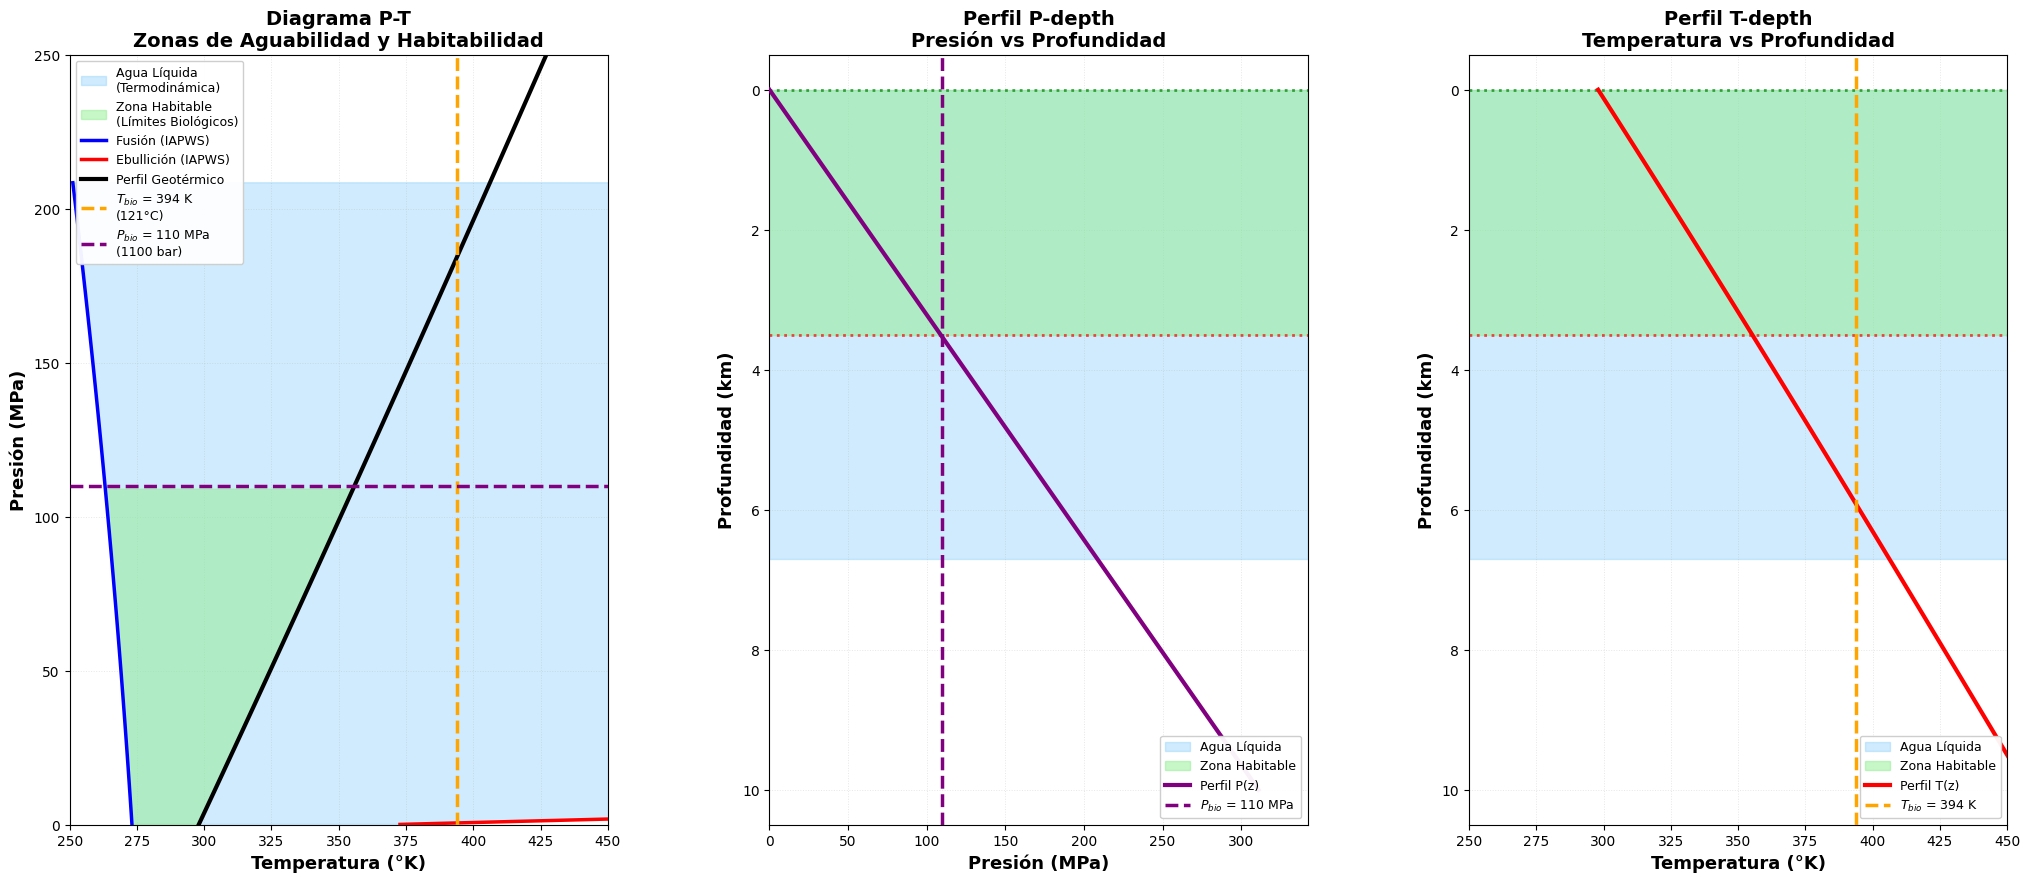

In [10]:
Graficos(df_geotherm, liquid_zone_data, habitable_zone_data)

### 4.8 Visualización: Diagramas P-T y Perfiles de Profundidad

Los siguientes gráficos muestran:

1. **Panel Izquierdo**: Diagrama Presión-Temperatura con curvas de fase IAPWS
2. **Panel Central**: Perfil Presión vs Profundidad con límites biológicos
3. **Panel Derecho**: Perfil Temperatura vs Profundidad con zonas marcadas

Las regiones sombreadas indican:
- 🔵 **Azul claro**: Zona de aguabilidad (agua líquida termodinámicamente estable)
- 🟢 **Verde**: Zona habitable (límites biológicos T < 121°C, P < 110 MPa)

---

## 5. Escenarios Planetarios: Efecto de la Distancia Orbital

### 5.1 Tierra a 1.52 UA (Órbita de Marte)

Exploramos cómo cambiaría la habitabilidad subsuperficial si la Tierra estuviera ubicada a la distancia orbital de Marte.

**Hipótesis**:
- ❄️ Mayor distancia al Sol → Menor temperatura superficial
- 🧊 Superficie congelada (capa de hielo permanente)
- 💧 Zona de aguabilidad subsuperficial reducida
- 🦠 Zona habitable más pequeña (limitada por presión)

**Parámetros del escenario**:
- Distancia: 1.52 AU (distancia orbital de Marte)
- Masa: 1.0 M⊕ (misma masa que la Tierra actual)
- Radio: 1.0 R⊕ (mismo radio que la Tierra actual)
- Flujo de calor interno: 65 mW/m² (mismo que la Tierra actual)
- Efecto invernadero: factor 1.1313 (atmósfera terrestre estándar)

In [11]:
# =============================================================================
# CÁLCULO: PERFIL GEOTÉRMICO A 1.52 UA
# =============================================================================

# Calcular temperatura superficial usando la función
d = 1.52  # AU (distancia orbital de Marte)
Tsurf_152 = T_eq(d)
print(f"Temperatura superficial a {d} AU: {Tsurf_152:.2f} K ({Tsurf_152-273.15:.1f}°C)")

# Calcular perfil geotérmico con superficie congelada
df_geotherm152 = gc.calculate_geotherm(
    rocks=rocks,
    q_s=65e-3,           # 65 mW/m² (mismo flujo de calor interno)
    z_max=10e3,          # 10 km 
    dz=100.0,           
    R_planet=Re,
    M_total=Me,
    boundaries=[16e3, 23e3, 39e3],
    T_top=Tsurf_152,
    A_surface=2.5e-6,
    h_r=10e3
)

Temperatura superficial a 1.52 AU: 234.14 K (-39.0°C)


In [12]:
# =============================================================================
# CÁLCULO: ZONAS DE AGUABILIDAD Y HABITABILIDAD A 1.52 UA
# =============================================================================

liquid_zone_data152 = find_liquid_zone(df_geotherm152, salinity=0.0, ice_type='Ih')
habitable_zone_data152 = find_habitable_zone(liquid_zone_data152['liquid_zone'], df_geotherm152)

liq_hab_zone_data(liquid_zone_data152, habitable_zone_data152)


💧 ZONA DE AGUABILIDAD (Agua Líquida):
   Profundidad: 2100.00 - 6600.00 km
   Temperatura: 267.69 - 333.10 K
   Presión: 65.50 - 205.67 MPa
   Espesor: 4.500 km

🦠 ZONA HABITABLE (Límites Biológicos):
   Profundidad: 2100.00 - 3500.00 km
   Temperatura: 267.69 - 288.68 K (-5.5 - 15.5°C)
   Presión: 65.50 - 109.10 MPa
   Espesor: 1.400 km

📊 Zona Habitable = 31.1% de la Zona de Aguabilidad



C:\Users\Santiago\AppData\Local\Temp\ipykernel_23076\3015452716.py:480: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


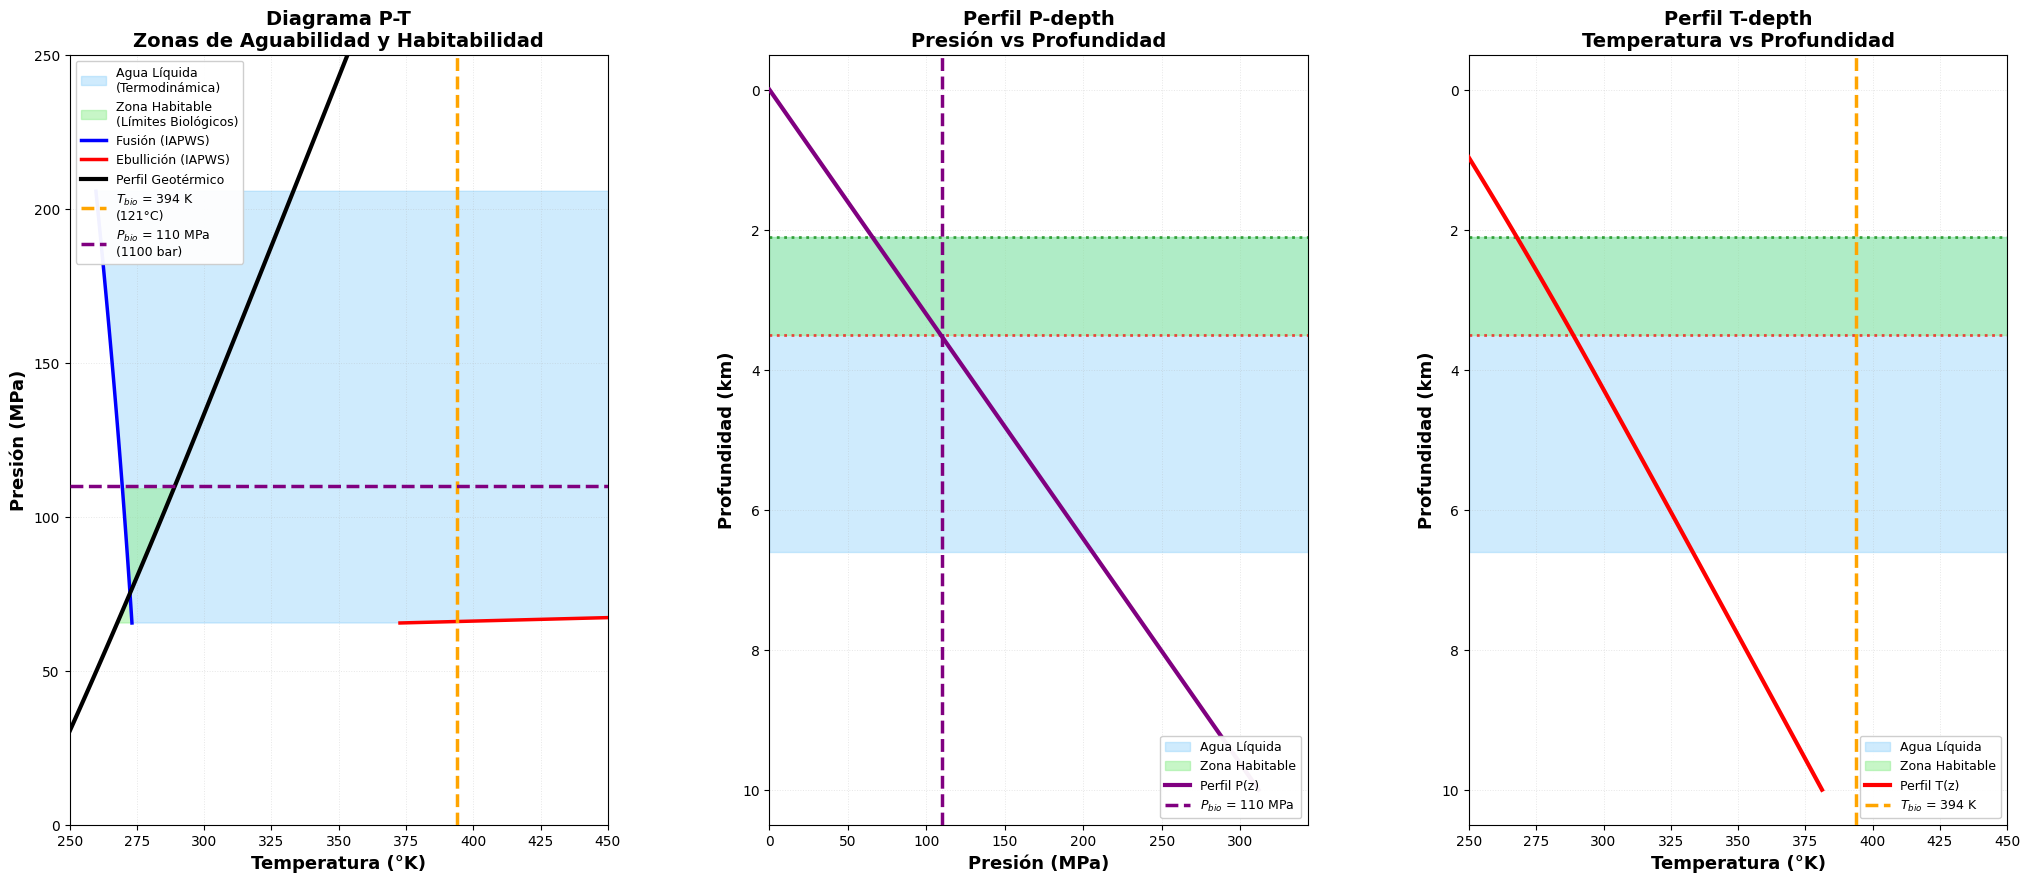

In [13]:
# =============================================================================
# VISUALIZACIÓN: TIERRA A 1.52 UA
# =============================================================================

Graficos(df_geotherm152, liquid_zone_data152, habitable_zone_data152)

### 5.2 Interpretación: Comparación entre Escenarios

| Parámetro | Tierra a 1.0 AU | Tierra a 1.52 AU |
|-----------|-----------------|------------------|
| **Temperatura superficial** | 298.0 K (25°C) | 233.6 K (-39.5°C) |
| **Estado superficial** | Líquido | Hielo sólido |
| **Zona de aguabilidad** | 0.0 - 6.7 km | 2.2 - 6.6 km |
| **Espesor zona aguabilidad** | 6.7 km | 4.4 km |
| **Zona habitable** | 0.0 - 3.5 km | 2.2 - 3.5 km |
| **Espesor zona habitable** | 3.5 km | 1.3 km |
| **Fracción habitable** | 52.2% | 29.5% |
| **Factor limitante** | Presión | Presión |

**Conclusiones**:
1. El aumento de distancia orbital reduce drásticamente la zona habitable subsuperficial (de 3.5 km a 1.3 km)
2. A 1.52 AU, la superficie está permanentemente congelada (T < 273 K), pero existe agua líquida subsuperficial entre 2.2-6.6 km de profundidad
3. La zona habitable comienza a mayor profundidad (2.2 km vs 0 km) debido a la baja temperatura superficial
4. Este escenario es análogo a lunas heladas como Europa y Encelado, donde océanos subsuperficiales existen bajo capas de hielo
5. La vida subsuperficial sigue siendo posible incluso con superficie congelada, sugiriendo que la habitabilidad planetaria no requiere agua superficial líquida
6. El factor limitante en ambos casos es la **presión** (~110 MPa a 3.5-3.7 km), no la temperatura


---

## 6. Análisis Paramétrico Interactivo

### 6.1 Explorador de Habitabilidad Planetaria

El siguiente widget interactivo permite explorar cómo cambia la zona habitable subsuperficial al variar:

**Parámetros Orbitales**:
- **Distancia orbital** (0.5 - 6.0 AU): Afecta la temperatura superficial
- **Luminosidad estelar** (0.1 - 10.0 L☉): Estrellas más brillantes o tenues que el Sol

**Parámetros Planetarios**:
- **Masa** (0.1 - 10.0 M⊕): Afecta la gravedad y el perfil de presión
- **Radio** (0.1 - 10.0 R⊕): Afecta la densidad y el gradiente de presión
- **Flujo de calor interno** (10 - 200 mW/m²): Energía geotérmica del interior

**Uso**:
1. Ajusta los sliders para explorar diferentes configuraciones planetarias
2. El modelo recalcula automáticamente el perfil geotérmico
3. Se muestran las zonas de aguabilidad y habitabilidad resultantes
4. Útil para identificar candidatos exoplanetarios habitables

In [14]:
@interact
def interactive_habitability(
    Distance_AU=widgets.FloatSlider(value=1.0, min=0.5, max=6.0, step=0.1, description='Distancia (AU):'),
    Planet_Mass=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Masa del planeta (M⊕):'),
    Planet_Radius=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Radio del planeta (R⊕):'),
    Star_Luminosity=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Luminosidad estelar (L*):'),
    Heat_Flux=widgets.FloatSlider(value=65.0, min=10.0, max=200.0, step=5.0, description='Flujo de calor superficial (mW/m²):'),
):
    print("=" * 80)
    print(f"ESCENARIO INTERACTIVO: Distancia = {Distance_AU:.3f} AU")
    print(f"ESCENARIO INTERACTIVO: Masa del planeta = {Planet_Mass:.3f} M⊕")
    print(f"ESCENARIO INTERACTIVO: Radio del planeta = {Planet_Radius:.3f} R⊕")
    print(f"ESCENARIO INTERACTIVO: Luminosidad estelar = {Star_Luminosity:.3f} L*")
    print(f"ESCENARIO INTERACTIVO: Flujo de calor superficial = {Heat_Flux:.3f} mW/m²")
    print("=" * 80)

    Tsurface = T_eq(
        distance_AU=Distance_AU,
        L_star=Star_Luminosity,
    )

    boundaries = gc.scale_layer_boundaries(R_planet=Planet_Radius * Re)
    
    df_geotherm = gc.calculate_geotherm(
        rocks=rocks,
        q_s=Heat_Flux * 1e-3,           # Convertir a W/m²
        z_max=10e3,         # 10 km
        dz=100.0,
        R_planet=Planet_Radius * Re,
        M_total=Planet_Mass * Me,
        boundaries=boundaries,
        T_top=Tsurface,
        A_surface=2.5e-6,
        h_r=10e3
    )

    liquid_zone_data_int = find_liquid_zone(df_geotherm)
    habitable_zone_data_int = find_habitable_zone(liquid_zone_data_int['liquid_zone'], df_geotherm)

    liq_hab_zone_data(liquid_zone_data_int, habitable_zone_data_int)

    if habitable_zone_data_int['habitable_zone'] is not None:
        Graficos(df_geotherm, liquid_zone_data_int, habitable_zone_data_int)

interactive(children=(FloatSlider(value=1.0, description='Distancia (AU):', max=6.0, min=0.5), FloatSlider(val…

---

### 6.2 Análisis de Sensibilidad: Zona Habitable vs Distancia Orbital

El siguiente análisis muestra cómo varía el **espesor de las zonas de aguabilidad y habitabilidad** en función de la distancia orbital.

**Metodología**:
- Calcula perfiles geotérmicos para distancias de 0.5 a 10.0 AU
- Identifica zonas de agua líquida y habitabilidad para cada caso
- Genera gráficos comparativos de espesor vs distancia

**Aplicaciones**:
- Determinar los límites de la **Zona Habitable Circunestelar** (HZ)
- Identificar la distancia óptima para maximizar la habitabilidad subsuperficial
- Evaluar candidatos exoplanetarios (TRAPPIST-1, Proxima Centauri b, etc.)

In [90]:
def habitability_vs_distance(
    Planet_Mass,
    Planet_Radius,
    Heat_Flux,
    Max_distance
):    
    
    distances_AU = np.linspace(0.5, Max_distance, 30)  
    water_thickness = []
    habitable_thickness = []
    water_depth_start = []
    habitable_depth_start = []
    surface_temps = []

    print("=" * 80)
    print("CALCULANDO CapaS DE HABITABILIDAD PARA DIFERENTES DISTANCIAS ORBITALES")
    print("=" * 80)

    boundaries = gc.scale_layer_boundaries(R_planet=Planet_Radius * Re)

    for d_AU in distances_AU:
        # Calcular temperatura superficial
        T_surf = T_eq(distance_AU=d_AU)
        surface_temps.append(T_surf)
        
        # Calcular perfil geotérmico
        df_temp = gc.calculate_geotherm(
            rocks=rocks,
            q_s=Heat_Flux * 1e-3,
            z_max=10e3,
            dz=100.0,
            R_planet=Planet_Radius * Re,
            M_total=Planet_Mass * Me,
            boundaries=boundaries,
            T_top=T_surf,
            A_surface=2.5e-6,
            h_r=10e3
        )
        
        # Calcular Capas
        liquid_data = find_liquid_zone(df_temp, salinity=0.0, ice_type='Ih', information=False)
        habitable_data = find_habitable_zone(liquid_data['liquid_zone'], df_temp, information=False)

        # Guardar espesores y profundidades iniciales
        if liquid_data['liquid_zone'] is not None:
            water_thick = (liquid_data['liquid_zone'][-1] - liquid_data['liquid_zone'][0]) / 1000  # km
            water_thickness.append(water_thick)
            water_depth_start.append(liquid_data['liquid_zone'][0] / 1000)  # km
        else:
            water_thickness.append(0)
            water_depth_start.append(np.nan)
        
        if habitable_data['habitable_zone'] is not None:
            hab_thick = (habitable_data['habitable_zone'][-1] - habitable_data['habitable_zone'][0]) / 1000  # km
            habitable_thickness.append(hab_thick)
            habitable_depth_start.append(habitable_data['habitable_zone'][0] / 1000)  # km
        else:
            habitable_thickness.append(0)
            habitable_depth_start.append(np.nan)
        

    # Convertir a arrays numpy
    water_thickness = np.array(water_thickness)
    habitable_thickness = np.array(habitable_thickness)
    water_depth_start = np.array(water_depth_start)
    habitable_depth_start = np.array(habitable_depth_start)
    surface_temps = np.array(surface_temps)

    data = {
        'distances_AU': distances_AU,
        'water_thickness': water_thickness,
        'habitable_thickness': habitable_thickness,
        'water_depth_start': water_depth_start,
        'habitable_depth_start': habitable_depth_start,
        'surface_temps': surface_temps,
        'attributes': {
            'Planet_Mass': Planet_Mass,
            'Planet_Radius': Planet_Radius,
            'Heat_Flux': Heat_Flux,
        }
    }


    return data

def plots_habitability_vs_distance(data):

    distances_AU = data['distances_AU']
    water_thickness = data['water_thickness']
    habitable_thickness = data['habitable_thickness']
    water_depth_start = data['water_depth_start']
    habitable_depth_start = data['habitable_depth_start']
    surface_temps = data['surface_temps']

    attributes = data['attributes']
    Planet_Mass = attributes['Planet_Mass']
    Planet_Radius = attributes['Planet_Radius']
    Heat_Flux = attributes['Heat_Flux']

    # =============================================================================
    # CREAR FIGURA CON TRES PANELES
    # =============================================================================

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # PANEL 1: ESPESOR vs DISTANCIA ORBITAL
    ax1.plot(distances_AU, water_thickness, 'b-', linewidth=3, marker='o', 
            markersize=6, label='Capa de Aguabilidad', zorder=3)
    ax1.plot(distances_AU, habitable_thickness, 'g-', linewidth=3, marker='s', 
            markersize=6, label='Capa Habitable', zorder=3)
    ax1.fill_between(distances_AU, 0, water_thickness, color='lightskyblue', alpha=0.3, zorder=1)
    ax1.fill_between(distances_AU, 0, habitable_thickness, color='lightgreen', alpha=0.4, zorder=2)

    # Marcar posición de la Tierra
    ax1.axvline(1.0, color='orange', linestyle='--', linewidth=2.5, alpha=0.7, 
                label='Tierra (1.0 AU)', zorder=4)

    ax1.set_xlabel('Distancia Orbital (AU)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Espesor de la Capa (km)', fontsize=13, fontweight='bold')
    ax1.set_title('Espesor de Capas de Agua Líquida y Habitabilidad\nvs Distancia Orbital', 
                fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=11, framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax1.set_xlim(0.5, 3.0)
    if max(water_thickness) > 0:
        ax1.set_ylim(0, max(water_thickness) * 1.1)

    # PANEL 2: PROFUNDIDAD INICIAL vs DISTANCIA ORBITAL
    # Filtrar valores válidos (no NaN)
    valid_water = ~np.isnan(water_depth_start)
    valid_hab = ~np.isnan(habitable_depth_start)
    
    if valid_water.any():
        ax2.plot(distances_AU[valid_water], water_depth_start[valid_water], 'b-', 
                linewidth=3, marker='o', markersize=6, label='Inicio Capa de Aguabilidad', zorder=3)
        ax2.fill_between(distances_AU[valid_water], 0, water_depth_start[valid_water], 
                        color='lightskyblue', alpha=0.3, zorder=1)
    
    if valid_hab.any():
        ax2.plot(distances_AU[valid_hab], habitable_depth_start[valid_hab], 'g-', 
                linewidth=3, marker='s', markersize=6, label='Inicio Capa Habitable', zorder=3)
        ax2.fill_between(distances_AU[valid_hab], 0, habitable_depth_start[valid_hab], 
                        color='lightgreen', alpha=0.4, zorder=2)
    
    # Marcar posición de la Tierra
    ax2.axvline(1.0, color='orange', linestyle='--', linewidth=2.5, alpha=0.7, 
                label='Tierra (1.0 AU)', zorder=4)
    
    ax2.set_xlabel('Distancia Orbital (AU)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Profundidad Inicial de la Capa (km)', fontsize=13, fontweight='bold')
    ax2.set_title('Profundidad de Inicio de Capas\nvs Distancia Orbital', 
                fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax2.set_xlim(0.5, 3.0)
    ax2.invert_yaxis()  # Invertir para que profundidad crezca hacia abajo

    # PANEL 3: TEMPERATURA SUPERFICIAL vs DISTANCIA
    ax3.plot(distances_AU, surface_temps, 'r-', linewidth=3, marker='D', 
            markersize=6, label='T superficie', zorder=3)
    ax3.axhline(273.15, color='blue', linestyle='--', linewidth=2, alpha=0.7, 
                label='Congelación H₂O (273 K)', zorder=2)
    ax3.axhline(394, color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
                label='Límite Biológico (394 K)', zorder=2)
    ax3.axvline(1.0, color='orange', linestyle='--', linewidth=2.5, alpha=0.7, 
                label='Tierra (1.0 AU)', zorder=4)
    
    # Sombrear Capa habitable superficial (273-394 K)
    ax3.axhspan(273.15, 394, color='lightgreen', alpha=0.2, zorder=1, 
                label='Rango habitable')

    ax3.set_xlabel('Distancia Orbital (AU)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Temperatura Superficial (K)', fontsize=13, fontweight='bold')
    ax3.set_title('Temperatura Superficial vs Distancia Orbital\n(con efecto invernadero)', 
                fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=10, framealpha=0.95)
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax3.set_xlim(0.5, 3.0)
    ax3.set_ylim(150, 450)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # ANÁLISIS DE RESULTADOS
    # =============================================================================

    print("\n" + "=" * 80)
    print("ANÁLISIS DE RESULTADOS")
    print("=" * 80)

    # Encontrar Capa habitable circunestelar (superficie entre 273-394 K)
    hz_mask = (surface_temps >= 273.15) & (surface_temps <= 394)
    if hz_mask.any():
        hz_indices = np.where(hz_mask)[0]
        hz_inner = distances_AU[hz_indices[0]]
        hz_outer = distances_AU[hz_indices[-1]]
        print(f"\n🌍 Capa HABITABLE CIRCUNESTELAR (Capa de Ricitos de Oro):")
        print(f"   Límite interno: {hz_inner:.2f} AU (T_surf = {surface_temps[hz_indices[0]]:.1f} K)")
        print(f"   Límite externo: {hz_outer:.2f} AU (T_surf = {surface_temps[hz_indices[-1]]:.1f} K)")
        print(f"   Ancho de la Capa: {hz_outer - hz_inner:.2f} AU")
    else:
        print(f"\n🌍 Capa HABITABLE CIRCUNESTELAR: No encontrada en el rango analizado")

    # Máximo espesor de Capa habitable subsuperficial
    if habitable_thickness.max() > 0:
        max_hab_idx = np.argmax(habitable_thickness)
        print(f"\n📊 MÁXIMO ESPESOR DE Capa HABITABLE SUBSUPERFICIAL:")
        print(f"   Distancia: {distances_AU[max_hab_idx]:.2f} AU")
        print(f"   Espesor: {habitable_thickness[max_hab_idx]:.2f} km")
        print(f"   Profundidad de inicio: {habitable_depth_start[max_hab_idx]:.2f} km")
        print(f"   T_superficie: {surface_temps[max_hab_idx]:.1f} K ({surface_temps[max_hab_idx]-273.15:.1f}°C)")
    
    # Máximo espesor de Capa de aguabilidad
    if water_thickness.max() > 0:
        max_water_idx = np.argmax(water_thickness)
        print(f"\n💧 MÁXIMO ESPESOR DE Capa DE AGUABILIDAD:")
        print(f"   Distancia: {distances_AU[max_water_idx]:.2f} AU")
        print(f"   Espesor: {water_thickness[max_water_idx]:.2f} km")
        print(f"   Profundidad de inicio: {water_depth_start[max_water_idx]:.2f} km")

    # Comparación con Tierra (1.0 AU)
    earth_idx = np.argmin(np.abs(distances_AU - 1.0))
    print(f"\n🌎 VALORES PARA LA TIERRA (1.0 AU):")
    print(f"   Temperatura superficial: {surface_temps[earth_idx]:.1f} K ({surface_temps[earth_idx]-273.15:.1f}°C)")
    print(f"   Capa de Aguabilidad: {water_thickness[earth_idx]:.2f} km (inicio: {water_depth_start[earth_idx]:.2f} km)")
    print(f"   Capa Habitable: {habitable_thickness[earth_idx]:.2f} km (inicio: {habitable_depth_start[earth_idx]:.2f} km)")
    if water_thickness[earth_idx] > 0 and habitable_thickness[earth_idx] > 0:
        print(f"   Fracción habitable: {(habitable_thickness[earth_idx]/water_thickness[earth_idx])*100:.1f}%")
    
    # Distancia donde aparece agua líquida subsuperficial
    water_exists = water_thickness > 0
    if water_exists.any():
        first_water_idx = np.where(water_exists)[0][0]
        last_water_idx = np.where(water_exists)[0][-1]
        print(f"\n🧊 RANGO CON AGUA LÍQUIDA SUBSUPERFICIAL:")
        print(f"   Desde: {distances_AU[first_water_idx]:.2f} AU (T_surf = {surface_temps[first_water_idx]:.1f} K)")
        print(f"   Hasta: {distances_AU[last_water_idx]:.2f} AU (T_surf = {surface_temps[last_water_idx]:.1f} K)")
        print(f"   Rango total: {distances_AU[last_water_idx] - distances_AU[first_water_idx]:.2f} AU")
    
    # Parámetros planetarios usados
    print(f"\n⚙️  PARÁMETROS PLANETARIOS:")
    print(f"   Masa: {Planet_Mass:.2f} M⊕")
    print(f"   Radio: {Planet_Radius:.2f} R⊕")
    print(f"   Flujo de calor interno: {Heat_Flux:.1f} mW/m²")
    print(f"   Densidad promedio: {(Planet_Mass/Planet_Radius**3):.2f} ρ⊕")

    print("\n" + "=" * 80)

CALCULANDO CapaS DE HABITABILIDAD PARA DIFERENTES DISTANCIAS ORBITALES


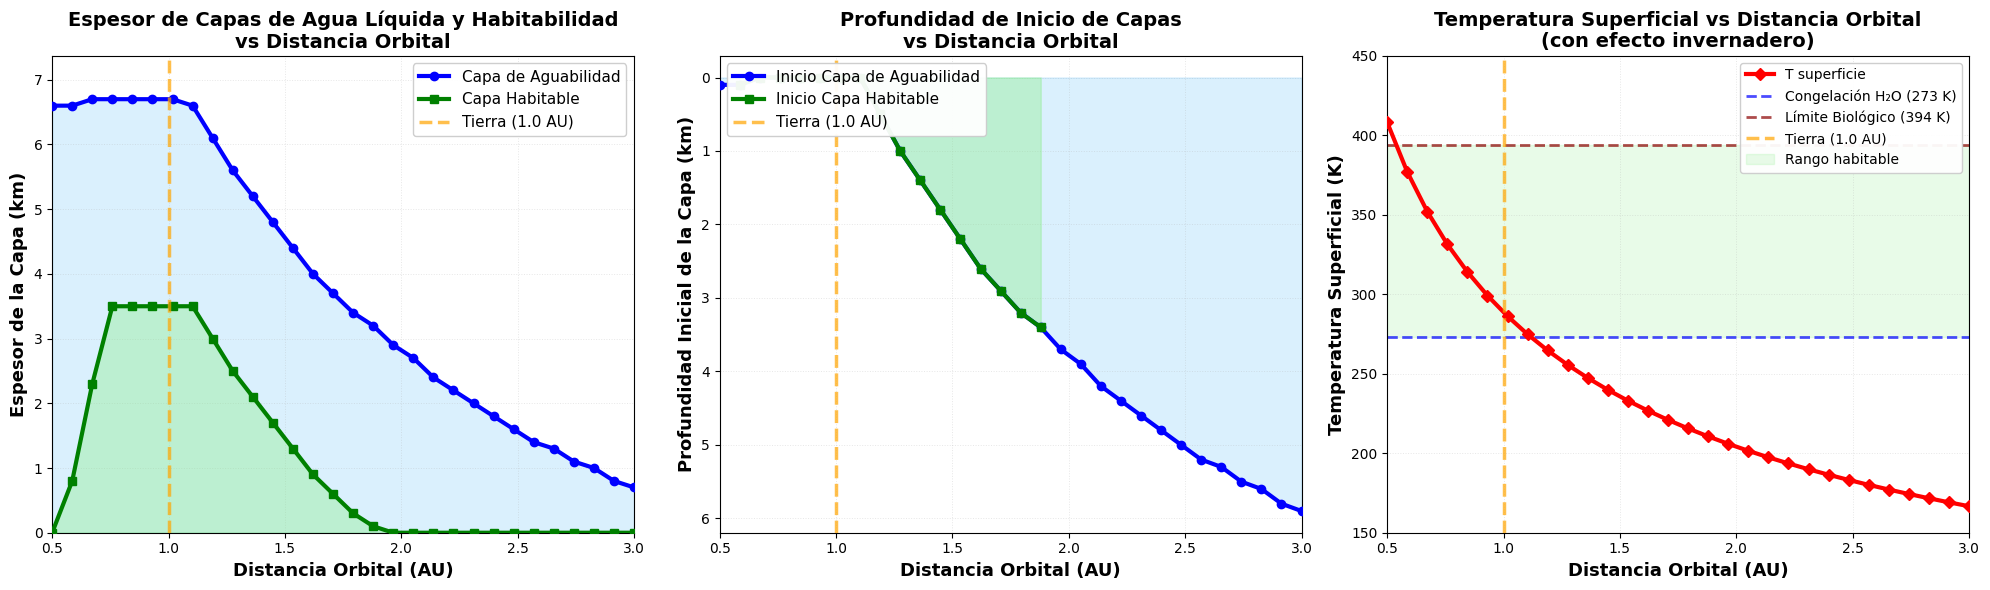


ANÁLISIS DE RESULTADOS

🌍 Capa HABITABLE CIRCUNESTELAR (Capa de Ricitos de Oro):
   Límite interno: 0.59 AU (T_surf = 377.0 K)
   Límite externo: 1.10 AU (T_surf = 274.8 K)
   Ancho de la Capa: 0.52 AU

📊 MÁXIMO ESPESOR DE Capa HABITABLE SUBSUPERFICIAL:
   Distancia: 0.76 AU
   Espesor: 3.50 km
   Profundidad de inicio: 0.00 km
   T_superficie: 331.4 K (58.3°C)

💧 MÁXIMO ESPESOR DE Capa DE AGUABILIDAD:
   Distancia: 0.67 AU
   Espesor: 6.70 km
   Profundidad de inicio: 0.00 km

🌎 VALORES PARA LA TIERRA (1.0 AU):
   Temperatura superficial: 286.2 K (13.1°C)
   Capa de Aguabilidad: 6.70 km (inicio: 0.00 km)
   Capa Habitable: 3.50 km (inicio: 0.00 km)
   Fracción habitable: 52.2%

🧊 RANGO CON AGUA LÍQUIDA SUBSUPERFICIAL:
   Desde: 0.50 AU (T_surf = 408.2 K)
   Hasta: 3.00 AU (T_surf = 166.7 K)
   Rango total: 2.50 AU

⚙️  PARÁMETROS PLANETARIOS:
   Masa: 1.00 M⊕
   Radio: 1.00 R⊕
   Flujo de calor interno: 65.0 mW/m²
   Densidad promedio: 1.00 ρ⊕



In [30]:
data = habitability_vs_distance(
    Planet_Mass=1.0,
    Planet_Radius=1.0,
    Heat_Flux=65.0,
    Max_distance=3.0
)

plots_habitability_vs_distance(data)

In [31]:
@interact
def interactive_habitability_vs_distance(
    Planet_Mass=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Masa del planeta (M⊕):'),
    Planet_Radius=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Radio del planeta (R⊕):'),
    Heat_Flux=widgets.FloatSlider(value=65.0, min=10.0, max=200.0, step=5.0, description='Flujo de calor superficial (mW/m²):'),
    Max_distance=widgets.FloatSlider(value=3.0, min=1.0, max=6.0, step=0.5, description='Distancia máxima (AU):'),
):
    data = habitability_vs_distance(
        Planet_Mass=Planet_Mass,
        Planet_Radius=Planet_Radius,
        Heat_Flux=Heat_Flux,
        Max_distance=Max_distance
    )
    plots_habitability_vs_distance(data)
    

interactive(children=(FloatSlider(value=1.0, description='Masa del planeta (M⊕):', max=10.0, min=0.1), FloatSl…

### Capa Habitable en el Tiempo

In [88]:
def habitability_vs_time_geological(rocks,
                                R_planet,
                                M_planet,
                                q0,
                                composition=None,
                                t_max=3.5,
                                information=True):
    
    boundaries = gc.scale_layer_boundaries(R_planet=Re)
    t_geological = np.linspace(0.0, t_max, 10)
    df_geothermic_evolution = gc.calculate_geotherm_evolution(
        rocks=rocks,
        R_planet=R_planet,
        M_total=M_planet,
        z_max=20e3,
        composition=composition,
        boundaries=boundaries,
        dz=100.0,
        q0=q0,
        tau=2.0,
        t_Ga=t_geological)
    

    t_Ga = df_geothermic_evolution['t_Ga']
    q_s = df_geothermic_evolution['q_s']
    profiles = df_geothermic_evolution['profiles']

    # Listas para almacenar resultados
    water_thickness_time = []
    habitable_thickness_time = []
    water_depth_top_time = []
    water_depth_bottom_time = []
    habitable_depth_top_time = []
    habitable_depth_bottom_time = []

    print("=" * 80)
    print("CALCULANDO CapaS DE HABITABILIDAD EN EL TIEMPO GEOLÓGICO")
    print("=" * 80)

    # Procesar cada perfil geotérmico en el tiempo
    for i, (t, q, df_profile) in enumerate(zip(t_Ga, q_s, profiles)):
        print(f"\nTiempo: {t:.2f} Ga | Flujo de calor: {q*1000:.1f} mW/m²")
        
        # Calcular Capas de habitabilidad
        liquid_data = find_liquid_zone(df_profile, information=False)
        habitable_data = find_habitable_zone(liquid_data['liquid_zone'], df_profile, information=False)
        
        # Almacenar datos de Capa de aguabilidad
        if liquid_data['liquid_zone'] is not None:
            water_top = liquid_data['liquid_zone'][0] / 1000  # km
            water_bottom = liquid_data['liquid_zone'][-1] / 1000  # km
            water_thick = water_bottom - water_top
            
            water_depth_top_time.append(water_top)
            water_depth_bottom_time.append(water_bottom)
            water_thickness_time.append(water_thick)
            if information:
                print(f"  💧 Capa de Aguabilidad: {water_top:.2f} - {water_bottom:.2f} km (espesor: {water_thick:.2f} km)")
        else:
            water_depth_top_time.append(np.nan)
            water_depth_bottom_time.append(np.nan)
            water_thickness_time.append(0)
            if information:
                print(f"  💧 Capa de Aguabilidad: No existe")
        
        # Almacenar datos de Capa habitable
        if habitable_data['habitable_zone'] is not None:
            hab_top = habitable_data['habitable_zone'][0] / 1000  # km
            hab_bottom = habitable_data['habitable_zone'][-1] / 1000  # km
            hab_thick = hab_bottom - hab_top
            
            habitable_depth_top_time.append(hab_top)
            habitable_depth_bottom_time.append(hab_bottom)
            habitable_thickness_time.append(hab_thick)

            if information:
                print(f"  🦠 Capa Habitable: {hab_top:.2f} - {hab_bottom:.2f} km (espesor: {hab_thick:.2f} km)")
        else:
            habitable_depth_top_time.append(np.nan)
            habitable_depth_bottom_time.append(np.nan)
            habitable_thickness_time.append(0)
            if information:
                print(f"  🦠 Capa Habitable: No existe")

    # Convertir a arrays numpy
    water_thickness_time = np.array(water_thickness_time)
    habitable_thickness_time = np.array(habitable_thickness_time)
    water_depth_top_time = np.array(water_depth_top_time)
    water_depth_bottom_time = np.array(water_depth_bottom_time)
    habitable_depth_top_time = np.array(habitable_depth_top_time)
    habitable_depth_bottom_time = np.array(habitable_depth_bottom_time)
    
    data_time = {
                't_Ga': t_Ga,
                'q_s': q_s,
                'water_thickness_time': water_thickness_time,
                'habitable_thickness_time': habitable_thickness_time,
                'water_depth_top_time': water_depth_top_time,
                'water_depth_bottom_time': water_depth_bottom_time,
                'habitable_depth_top_time': habitable_depth_top_time,
                'habitable_depth_bottom_time': habitable_depth_bottom_time,
                'attributes': {
                    'R_planet': R_planet,
                    'M_planet': M_planet,
                    'q0': q0,
                    'composition': composition,
                }
        }
    
    return data_time

def plots_habitability_vs_time_geological(data_time):
    t_Ga = data_time['t_Ga']
    water_thickness_time = data_time['water_thickness_time']
    habitable_thickness_time = data_time['habitable_thickness_time']
    water_depth_top_time = data_time['water_depth_top_time']
    water_depth_bottom_time = data_time['water_depth_bottom_time']
    habitable_depth_top_time = data_time['habitable_depth_top_time']
    habitable_depth_bottom_time = data_time['habitable_depth_bottom_time']
    attributes = data_time['attributes']
    R_planet = attributes['R_planet']
    M_planet = attributes['M_planet']
    q0 = attributes['q0']
    composition = attributes['composition']

    # =============================================================================
    # VISUALIZACIÓN: EVOLUCIÓN TEMPORAL DE CapaS DE HABITABILIDAD
    # =============================================================================

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # PANEL 1: ESPESOR DE CapaS vs TIEMPO
    ax1 = axes[0, 0]
    ax1.plot(t_Ga, water_thickness_time, 'b-', linewidth=3, marker='o', 
            markersize=8, label='Capa de Aguabilidad', zorder=3)
    ax1.plot(t_Ga, habitable_thickness_time, 'g-', linewidth=3, marker='s', 
            markersize=8, label='Capa Habitable', zorder=3)
    ax1.fill_between(t_Ga, 0, water_thickness_time, color='lightskyblue', alpha=0.3, zorder=1)
    ax1.fill_between(t_Ga, 0, habitable_thickness_time, color='lightgreen', alpha=0.4, zorder=2)

    ax1.set_xlabel('Tiempo (Ga)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Espesor de la Capa (km)', fontsize=13, fontweight='bold')
    ax1.set_title('Evolución del Espesor de Capas Habitables\nen el Tiempo Geológico', 
                fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax1.set_xlim(0, max(t_Ga))
    ax1.set_ylim(0, max(water_thickness_time) * 1.1)

    # PANEL 2: PROFUNDIDAD DE LÍMITES DE Capa DE AGUABILIDAD vs TIEMPO
    ax2 = axes[0, 1]
    # Filtrar NaN para graficar
    valid_water = ~np.isnan(water_depth_top_time)
    if valid_water.any():
        ax2.plot(t_Ga[valid_water], water_depth_top_time[valid_water], 'b--', 
                linewidth=2.5, marker='o', markersize=7, label='Tope Capa de Aguabilidad', zorder=3)
        ax2.plot(t_Ga[valid_water], water_depth_bottom_time[valid_water], 'b-', 
                linewidth=2.5, marker='o', markersize=7, label='Base Capa de Aguabilidad', zorder=3)
        ax2.fill_between(t_Ga[valid_water], water_depth_top_time[valid_water], 
                        water_depth_bottom_time[valid_water], 
                        color='lightskyblue', alpha=0.4, zorder=1)

    ax2.set_xlabel('Tiempo (Ga)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Profundidad (km)', fontsize=13, fontweight='bold')
    ax2.set_title('Evolución de Límites de Capa de Aguabilidad\ncon el Tiempo', 
                fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=10, framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax2.invert_yaxis()  # Profundidad crece hacia abajo
    ax2.set_xlim(0, max(t_Ga))

    # PANEL 3: PROFUNDIDAD DE LÍMITES DE Capa HABITABLE vs TIEMPO
    ax3 = axes[1, 0]
    # Filtrar NaN para graficar
    valid_hab = ~np.isnan(habitable_depth_top_time)
    if valid_hab.any():
        ax3.plot(t_Ga[valid_hab], habitable_depth_top_time[valid_hab], 'g--', 
                linewidth=2.5, marker='s', markersize=7, label='Tope Capa Habitable', zorder=3)
        ax3.plot(t_Ga[valid_hab], habitable_depth_bottom_time[valid_hab], 'g-', 
                linewidth=2.5, marker='s', markersize=7, label='Base Capa Habitable', zorder=3)
        ax3.fill_between(t_Ga[valid_hab], habitable_depth_top_time[valid_hab], 
                        habitable_depth_bottom_time[valid_hab], 
                        color='lightgreen', alpha=0.5, zorder=1)

    ax3.set_xlabel('Tiempo (Ga)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Profundidad (km)', fontsize=13, fontweight='bold')
    ax3.set_title('Evolución de Límites de Capa Habitable\ncon el Tiempo', 
                fontsize=14, fontweight='bold')
    ax3.legend(loc='upper left', fontsize=10, framealpha=0.95)
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax3.invert_yaxis()  # Profundidad crece hacia abajo
    ax3.set_xlim(0, max(t_Ga))

    # PANEL 4: FRACCIÓN HABITABLE vs TIEMPO
    ax4 = axes[1, 1]
    # Calcular fracción habitable (evitar división por cero)
    frac_habitable = np.where(water_thickness_time > 0, 
                            (habitable_thickness_time / water_thickness_time) * 100, 
                            0)
    ax4.plot(t_Ga, frac_habitable, 'purple', linewidth=3, marker='D', 
            markersize=8, label='Fracción Habitable', zorder=3)
    ax4.fill_between(t_Ga, 0, frac_habitable, color='plum', alpha=0.4, zorder=1)
    ax4.axhline(50, color='red', linestyle='--', linewidth=2, alpha=0.5, 
                label='50% de referencia', zorder=2)

    ax4.set_xlabel('Tiempo (Ga)', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Fracción Habitable (%)', fontsize=13, fontweight='bold')
    ax4.set_title('Fracción de Capa de Aguabilidad que es Habitable\nvs Tiempo', 
                fontsize=14, fontweight='bold')
    ax4.legend(loc='best', fontsize=11, framealpha=0.95)
    ax4.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax4.set_xlim(0, max(t_Ga))
    ax4.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # RESUMEN ESTADÍSTICO
    # =============================================================================

    print("\n" + "=" * 80)
    print("RESUMEN ESTADÍSTICO: EVOLUCIÓN TEMPORAL DE HABITABILIDAD")
    print("=" * 80)

    print(f"\n📊 Capa DE AGUABILIDAD:")
    print(f"   Espesor inicial (0 Ga): {water_thickness_time[0]:.2f} km")
    print(f"   Espesor final ({t_Ga[-1]:.2f} Ga): {water_thickness_time[-1]:.2f} km")
    print(f"   Cambio total: {water_thickness_time[-1] - water_thickness_time[0]:+.2f} km")
    print(f"   Máximo espesor: {water_thickness_time.max():.2f} km (a {t_Ga[np.argmax(water_thickness_time)]:.2f} Ga)")

    print(f"\n🦠 Capa HABITABLE:")
    print(f"   Espesor inicial (0 Ga): {habitable_thickness_time[0]:.2f} km")
    print(f"   Espesor final ({t_Ga[-1]:.2f} Ga): {habitable_thickness_time[-1]:.2f} km")
    print(f"   Cambio total: {habitable_thickness_time[-1] - habitable_thickness_time[0]:+.2f} km")
    print(f"   Máximo espesor: {habitable_thickness_time.max():.2f} km (a {t_Ga[np.argmax(habitable_thickness_time)]:.2f} Ga)")

    print(f"\n📉 FRACCIÓN HABITABLE:")
    print(f"   Inicial (0 Ga): {frac_habitable[0]:.1f}%")
    print(f"   Final ({t_Ga[-1]:.2f} Ga): {frac_habitable[-1]:.1f}%")
    print(f"   Cambio total: {frac_habitable[-1] - frac_habitable[0]:+.1f}%")

    print("\n" + "=" * 80)

CALCULANDO EVOLUCIÓN TEMPORAL DEL GRADIENTE GEOTÉRMICO
Modelo: Turcotte & Schubert (2014)
Número de tiempos: 10
R_planet = 6.378 x 10^6 m
M_total = 5.972 x 10^24 kg
  t =  0.000 Ga | q_s =   65.0 mW/m² | dT/dz =  16.4 K/km
  t =  0.389 Ga | q_s =   79.0 mW/m² | dT/dz =  19.9 K/km
  t =  0.778 Ga | q_s =   95.9 mW/m² | dT/dz =  24.3 K/km
  t =  1.167 Ga | q_s =  116.5 mW/m² | dT/dz =  29.6 K/km
  t =  1.556 Ga | q_s =  141.5 mW/m² | dT/dz =  36.2 K/km
  t =  1.944 Ga | q_s =  171.8 mW/m² | dT/dz =  44.2 K/km
  t =  2.333 Ga | q_s =  208.7 mW/m² | dT/dz =  54.2 K/km
  t =  2.722 Ga | q_s =  253.5 mW/m² | dT/dz =  66.5 K/km
  t =  3.111 Ga | q_s =  308.0 mW/m² | dT/dz =  81.8 K/km
⚠️  T calculada (2155.4 K) excede límite seguro en z = 16.00 km
   Deteniendo cálculo en capa 160.

📊 Perfil parcial retornado:
   Profundidad calculada: 0 - 16.00 km (de 20.0 km solicitados)
   Temperatura máxima alcanzada: 2145.4 K
   Capas calculadas: 161 / 201
   Porcentaje completado: 80.1%

  t =  3.500 Ga

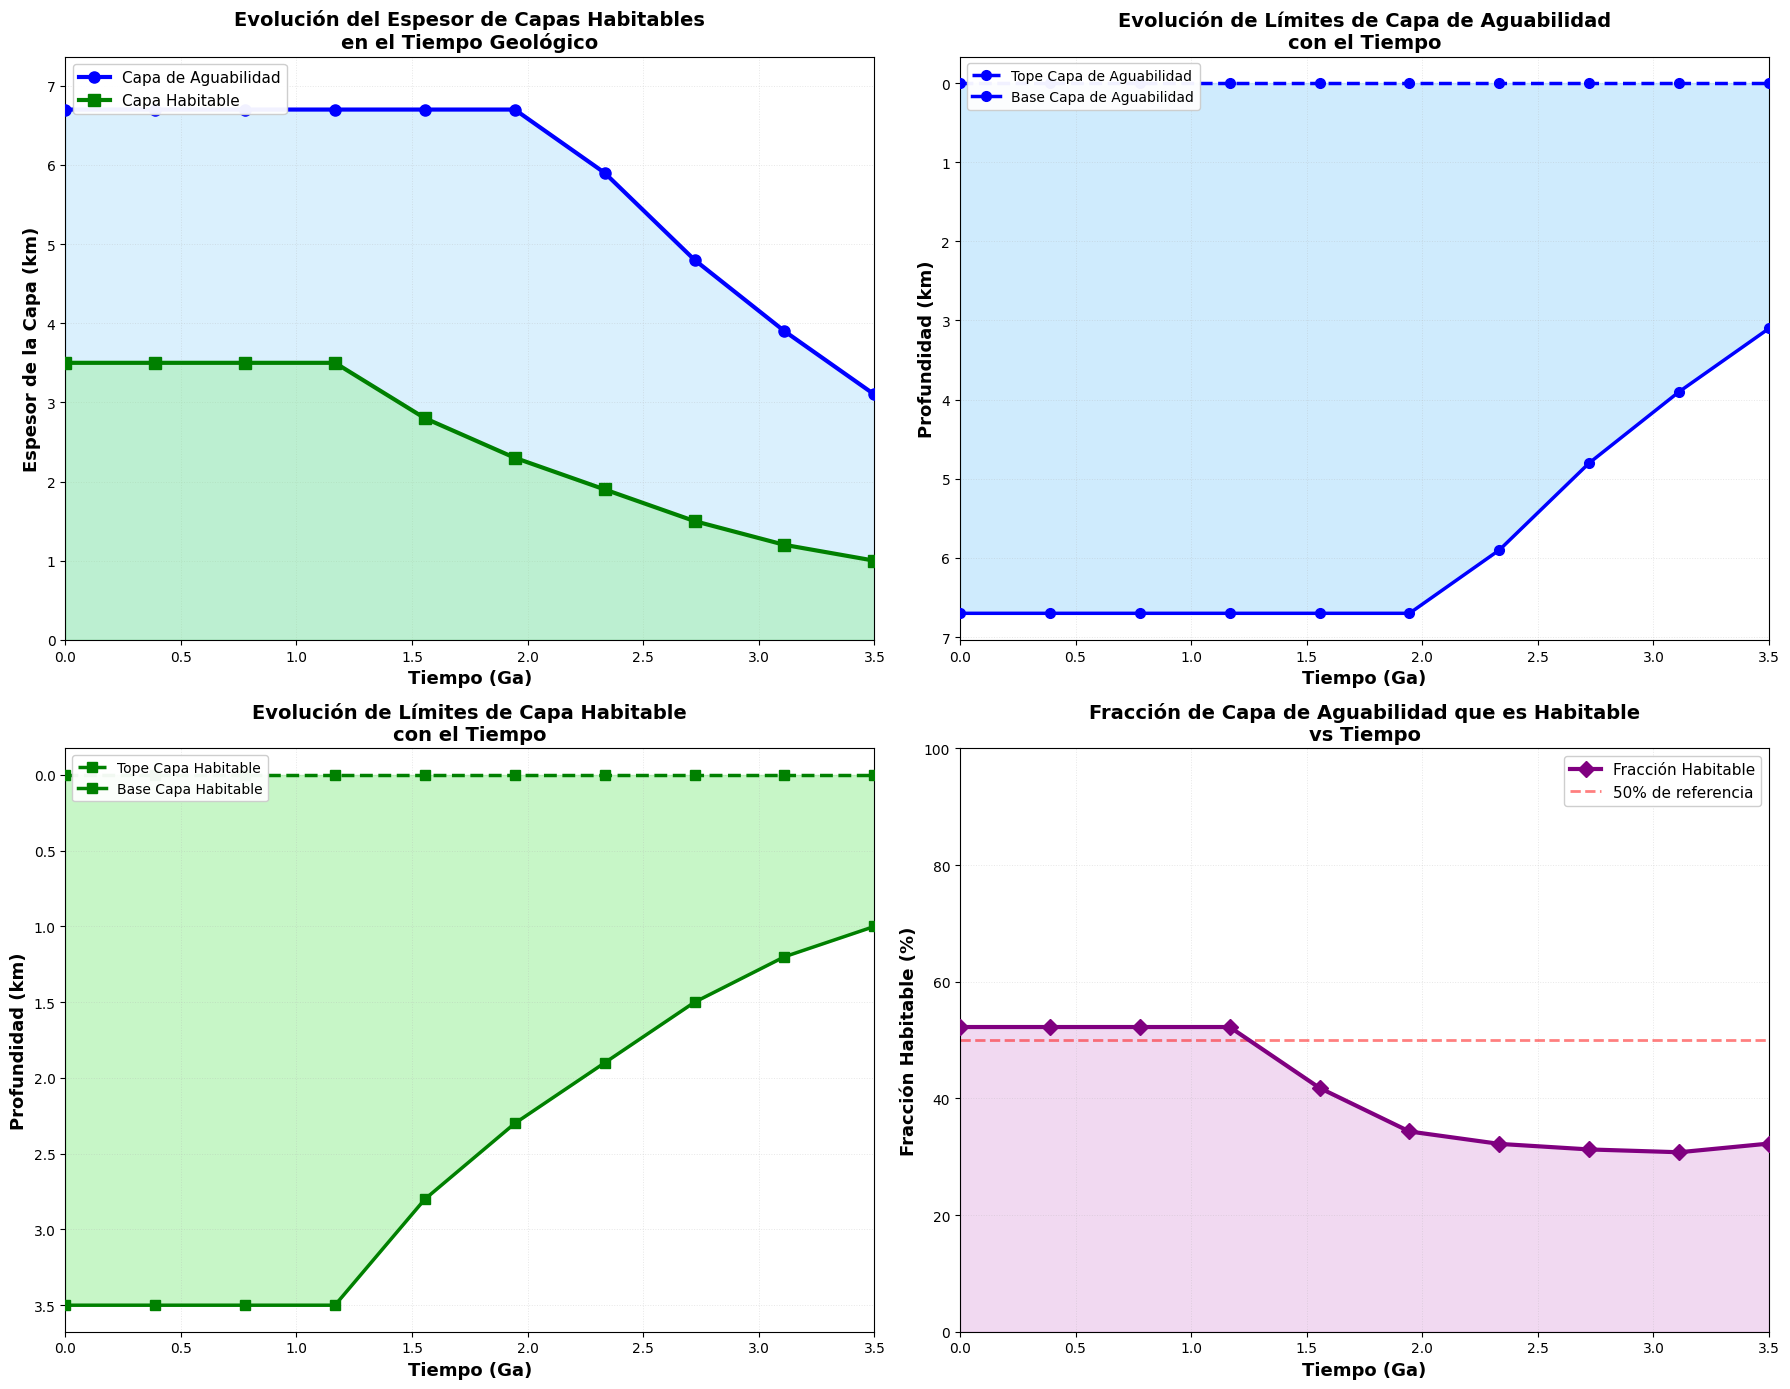


RESUMEN ESTADÍSTICO: EVOLUCIÓN TEMPORAL DE HABITABILIDAD

📊 Capa DE AGUABILIDAD:
   Espesor inicial (0 Ga): 6.70 km
   Espesor final (3.50 Ga): 3.10 km
   Cambio total: -3.60 km
   Máximo espesor: 6.70 km (a 0.00 Ga)

🦠 Capa HABITABLE:
   Espesor inicial (0 Ga): 3.50 km
   Espesor final (3.50 Ga): 1.00 km
   Cambio total: -2.50 km
   Máximo espesor: 3.50 km (a 0.00 Ga)

📉 FRACCIÓN HABITABLE:
   Inicial (0 Ga): 52.2%
   Final (3.50 Ga): 32.3%
   Cambio total: -20.0%



In [ ]:
data_time = habitability_vs_time_geological(rocks=rocks,
                                R_planet=Re,
                                M_planet=Me,
                                q0=60e-3,
                                information=False)
plots_habitability_vs_time_geological(data_time)

### Diagramas de Contorno

In [83]:
def habitability_vs_distance_heatflux(max_distance, max_heatflux=200e-3):

    ds = np.linspace(0.5, max_distance, 6)
    qs = np.linspace(40e-3, max_heatflux, 6)

    water_thickness_grid = np.zeros((len(ds), len(qs)))
    habitable_thickness_grid = np.zeros((len(ds), len(qs)))
    water_depth_top_grid = np.zeros((len(ds), len(qs)))
    water_depth_bottom_grid = np.zeros((len(ds), len(qs)))
    habitable_depth_top_grid = np.zeros((len(ds), len(qs)))
    habitable_depth_bottom_grid = np.zeros((len(ds), len(qs)))


    for i, distance in enumerate(ds):
        print(f'Distancia: {distance}')
        for j, q in enumerate(qs):
            T_surf = T_eq(distance_AU=distance)
            
            df_geotherm_sim = gc.calculate_geotherm(
                rocks=rocks,
                q_s=q,
                z_max=20e3,
                dz=100.0,
                R_planet=Re,
                M_total=Me,
                boundaries=gc.scale_layer_boundaries(R_planet=Re),
                T_top=T_surf,
                A_surface=2.5e-6,
                h_r=10e3
            )

            liquid_zone_data = find_liquid_zone(df_geotherm_sim, salinity=0.0, ice_type='Ih', information=False)
            
            if liquid_zone_data['liquid_zone'] is not None:
                habitable_zone_data = find_habitable_zone(liquid_zone_data['liquid_zone'], df_geotherm_sim, information=False)
                
                liq_top = liquid_zone_data['liquid_zone'][0]
                liq_bot = liquid_zone_data['liquid_zone'][-1]
                liq_thickness = (liq_bot - liq_top)
                water_thickness_grid[i, j] = liq_thickness / 1000  # km
                water_depth_top_grid[i, j] = liq_top / 1000  # km
                water_depth_bottom_grid[i, j] = liq_bot / 1000  # km

                # Verificar zona habitable
                if habitable_zone_data is not None and habitable_zone_data['habitable_zone'] is not None:
                    bio_top = habitable_zone_data['habitable_zone'][0]
                    bio_bot = habitable_zone_data['habitable_zone'][-1]
                    bio_thickness = (bio_bot - bio_top)
                    habitable_thickness_grid[i, j] = bio_thickness / 1000  # km
                    habitable_depth_top_grid[i, j] = bio_top / 1000  # km
                    habitable_depth_bottom_grid[i, j] = bio_bot / 1000  # km

    data_grid = {
        'distances_AU': ds,
        'heat_fluxes': qs,
        'water_thickness_grid': water_thickness_grid,
        'habitable_thickness_grid': habitable_thickness_grid,
        'water_depth_top_grid': water_depth_top_grid,
        'water_depth_bottom_grid': water_depth_bottom_grid,
        'habitable_depth_top_grid': habitable_depth_top_grid,
        'habitable_depth_bottom_grid': habitable_depth_bottom_grid,
    }
    return data_grid

In [84]:
def plots_habitability_contours(data_grid, kopparapu_limits=None):

    ds = data_grid['distances_AU']
    qs = data_grid['heat_fluxes']
    water_thickness_grid = data_grid['water_thickness_grid']
    habitable_thickness_grid = data_grid['habitable_thickness_grid']
    water_depth_top_grid = data_grid['water_depth_top_grid']
    habitable_depth_top_grid = data_grid['habitable_depth_top_grid']

    # =============================================================================
    # DIAGRAMAS DE CONTORNO: HABITABILIDAD vs DISTANCIA ORBITAL y FLUJO DE CALOR
    # =============================================================================

    fig, axes = plt.subplots(2, 3, figsize=(22, 14))
    fig.suptitle('Análisis Paramétrico: Zona Habitable vs Distancia Orbital y Flujo de Calor', 
                fontsize=16, fontweight='bold', y=0.995)

    # Crear meshgrid para contornos
    D, Q = np.meshgrid(ds, qs)

    # =============================================================================
    # PANEL 1: ESPESOR DE ZONA DE AGUABILIDAD
    # =============================================================================
    ax1 = axes[0, 0]
    contour1 = ax1.contourf(D, Q*1000, water_thickness_grid.T, levels=15, cmap='Blues')
    contour1_lines = ax1.contour(D, Q*1000, water_thickness_grid.T, levels=10, colors='black', 
                                linewidths=0.5, alpha=0.4)
    ax1.clabel(contour1_lines, inline=True, fontsize=9, fmt='%.1f km')
    cbar1 = plt.colorbar(contour1, ax=ax1, label='Espesor (km)')
    ax1.scatter(1.0, 65, color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                label='Tierra (1.0 AU, 65 mW/m²)', zorder=10)
    ax1.set_xlabel('Distancia Orbital (AU)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Flujo de Calor (mW/m²)', fontsize=12, fontweight='bold')
    ax1.set_title('Espesor de Zona de Aguabilidad', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)

    # =============================================================================
    # PANEL 2: ESPESOR DE ZONA HABITABLE
    # =============================================================================
    ax2 = axes[0, 1]
    contour2 = ax2.contourf(D, Q*1000, habitable_thickness_grid.T, levels=15, cmap='Greens')
    contour2_lines = ax2.contour(D, Q*1000, habitable_thickness_grid.T, levels=10, colors='black', 
                                linewidths=0.5, alpha=0.4)
    ax2.clabel(contour2_lines, inline=True, fontsize=9, fmt='%.1f km')
    cbar2 = plt.colorbar(contour2, ax=ax2, label='Espesor (km)')
    ax2.scatter(1.0, 65, color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                label='Tierra (1.0 AU, 65 mW/m²)', zorder=10)
    ax2.set_xlabel('Distancia Orbital (AU)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Flujo de Calor (mW/m²)', fontsize=12, fontweight='bold')
    ax2.set_title('Espesor de Zona Habitable', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)

    # =============================================================================
    # PANEL 3: PROFUNDIDAD INICIAL DE ZONA DE AGUABILIDAD
    # =============================================================================
    ax3 = axes[0, 2]
    contour3 = ax3.contourf(D, Q*1000, water_depth_top_grid.T, levels=15, cmap='Blues_r')
    contour3_lines = ax3.contour(D, Q*1000, water_depth_top_grid.T, levels=10, colors='black', 
                                linewidths=0.5, alpha=0.4)
    ax3.clabel(contour3_lines, inline=True, fontsize=9, fmt='%.1f km')
    cbar3 = plt.colorbar(contour3, ax=ax3, label='Profundidad (km)')
    ax3.scatter(1.0, 65, color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                label='Tierra (1.0 AU, 65 mW/m²)', zorder=10)
    ax3.set_xlabel('Distancia Orbital (AU)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Flujo de Calor (mW/m²)', fontsize=12, fontweight='bold')
    ax3.set_title('Profundidad Inicial de Zona de Aguabilidad', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=10)
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)

    # =============================================================================
    # PANEL 4: PROFUNDIDAD INICIAL DE ZONA HABITABLE
    # =============================================================================
    ax4 = axes[1, 0]
    contour4 = ax4.contourf(D, Q*1000, habitable_depth_top_grid.T, levels=15, cmap='Greens_r')
    contour4_lines = ax4.contour(D, Q*1000, habitable_depth_top_grid.T, levels=10, colors='black', 
                                linewidths=0.5, alpha=0.4)
    ax4.clabel(contour4_lines, inline=True, fontsize=9, fmt='%.1f km')
    cbar4 = plt.colorbar(contour4, ax=ax4, label='Profundidad (km)')
    ax4.scatter(1.0, 65, color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                label='Tierra (1.0 AU, 65 mW/m²)', zorder=10)
    ax4.set_xlabel('Distancia Orbital (AU)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Flujo de Calor (mW/m²)', fontsize=12, fontweight='bold')
    ax4.set_title('Profundidad Inicial de Zona Habitable', fontsize=13, fontweight='bold')
    ax4.legend(loc='upper right', fontsize=10)
    ax4.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)

    # =============================================================================
    # PANEL 5: FRACCIÓN HABITABLE (%)
    # =============================================================================
    ax5 = axes[1, 1]
    # Calcular fracción habitable (evitar división por cero)
    fraction_habitable = np.where(water_thickness_grid.T > 0, 
                                (habitable_thickness_grid.T / water_thickness_grid.T) * 100, 
                                0)
    contour5 = ax5.contourf(D, Q*1000, fraction_habitable, levels=15, cmap='RdYlGn')
    contour5_lines = ax5.contour(D, Q*1000, fraction_habitable, levels=10, colors='black', 
                                linewidths=0.5, alpha=0.4)
    ax5.clabel(contour5_lines, inline=True, fontsize=9, fmt='%.0f%%')
    cbar5 = plt.colorbar(contour5, ax=ax5, label='Fracción Habitable (%)')
    ax5.scatter(1.0, 65, color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                label='Tierra (1.0 AU, 65 mW/m²)', zorder=10)
    ax5.set_xlabel('Distancia Orbital (AU)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Flujo de Calor (mW/m²)', fontsize=12, fontweight='bold')
    ax5.set_title('Fracción de Zona de Aguabilidad que es Habitable', fontsize=13, fontweight='bold')
    ax5.legend(loc='upper right', fontsize=10)
    ax5.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)

    # =============================================================================
    # PANEL 6: MAPA DE EXISTENCIA DE ZONA HABITABLE
    # =============================================================================
    ax6 = axes[1, 2]
    # Crear máscara binaria: 1 si existe zona habitable, 0 si no
    habitability_exists = (habitable_thickness_grid.T > 0).astype(int)
    contour6 = ax6.contourf(D, Q*1000, habitability_exists, levels=[0, 0.5, 1], 
                            colors=['#ffcccc', '#ccffcc'], alpha=0.7)
    contour6_lines = ax6.contour(D, Q*1000, habitability_exists, levels=[0.5], 
                                colors='black', linewidths=2.5)
    ax6.scatter(1.0, 65, color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                label='Tierra (1.0 AU, 65 mW/m²)', zorder=10)

    # Añadir leyenda personalizada
    legend_elements = [
        Patch(facecolor='#ccffcc', edgecolor='black', label='Zona Habitable Existe'),
        Patch(facecolor='#ffcccc', edgecolor='black', label='Sin Zona Habitable'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15, 
                markeredgecolor='black', markeredgewidth=1.5, label='Tierra Actual')
    ]
    ax6.legend(handles=legend_elements, loc='upper right', fontsize=10)

    ax6.set_xlabel('Distancia Orbital (AU)', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Flujo de Calor (mW/m²)', fontsize=12, fontweight='bold')
    ax6.set_title('Existencia de Zona Habitable Subsuperficial', fontsize=13, fontweight='bold')
    ax6.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)

    if kopparapu_limits is not None:
        for limit_name, distance_AU in kopparapu_limits.items():
            for ax in axes.flatten():
                ax.axvline(distance_AU, color='purple', linestyle='--', linewidth=2, 
                           label=f'{limit_name} ({distance_AU:.2f} AU)')
        # Añadir leyenda general
        handles, labels = ax1.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax1.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # RESUMEN ESTADÍSTICO
    # =============================================================================

    print("\n" + "=" * 80)
    print("RESUMEN ESTADÍSTICO: ANÁLISIS PARAMÉTRICO")
    print("=" * 80)

    print(f"\n📊 ZONA DE AGUABILIDAD:")
    print(f"   Espesor máximo: {water_thickness_grid.max():.2f} km")
    idx_max_water = np.unravel_index(water_thickness_grid.argmax(), water_thickness_grid.shape)
    print(f"   En: d = {ds[idx_max_water[0]]:.2f} AU, q = {qs[idx_max_water[1]]*1000:.0f} mW/m²")
    print(f"   Espesor mínimo (excluyendo cero): {water_thickness_grid[water_thickness_grid > 0].min():.2f} km")

    print(f"\n🦠 ZONA HABITABLE:")
    print(f"   Espesor máximo: {habitable_thickness_grid.max():.2f} km")
    idx_max_hab = np.unravel_index(habitable_thickness_grid.argmax(), habitable_thickness_grid.shape)
    print(f"   En: d = {ds[idx_max_hab[0]]:.2f} AU, q = {qs[idx_max_hab[1]]*1000:.0f} mW/m²")
    print(f"   Número de escenarios con zona habitable: {(habitable_thickness_grid > 0).sum()}/{habitable_thickness_grid.size}")
    print(f"   Porcentaje de escenarios habitables: {(habitable_thickness_grid > 0).sum()/habitable_thickness_grid.size * 100:.1f}%")

    print(f"\n📈 FRACCIÓN HABITABLE:")
    print(f"   Máxima: {fraction_habitable.max():.1f}%")
    idx_max_frac = np.unravel_index(fraction_habitable.argmax(), fraction_habitable.shape)
    print(f"   En: d = {ds[idx_max_frac[1]]:.2f} AU, q = {qs[idx_max_frac[0]]*1000:.0f} mW/m²")
    print(f"   Promedio (donde existe habitabilidad): {fraction_habitable[fraction_habitable > 0].mean():.1f}%")

    print(f"\n🌍 VALORES PARA LA TIERRA (1.0 AU, 65 mW/m²):")
    # Encontrar índice más cercano a Tierra
    idx_earth_d = np.argmin(np.abs(ds - 1.0))
    idx_earth_q = np.argmin(np.abs(qs - 0.065))
    print(f"   Zona de Aguabilidad: {water_thickness_grid[idx_earth_d, idx_earth_q]:.2f} km")
    print(f"   Zona Habitable: {habitable_thickness_grid[idx_earth_d, idx_earth_q]:.2f} km")
    print(f"   Fracción Habitable: {fraction_habitable[idx_earth_q, idx_earth_d]:.1f}%")
    print(f"   Profundidad inicial agua: {water_depth_top_grid[idx_earth_d, idx_earth_q]:.2f} km")
    print(f"   Profundidad inicial habitable: {habitable_depth_top_grid[idx_earth_d, idx_earth_q]:.2f} km")

Distancia: 0.5
Distancia: 1.0
Distancia: 1.0
Distancia: 1.5
Distancia: 1.5
Distancia: 2.0
Distancia: 2.0
Distancia: 2.5
Distancia: 2.5
Distancia: 3.0
Distancia: 3.0


C:\Users\Santiago\AppData\Local\Temp\ipykernel_23076\1396446383.py:95: RuntimeWarning: invalid value encountered in divide
  (habitable_thickness_grid.T / water_thickness_grid.T) * 100,


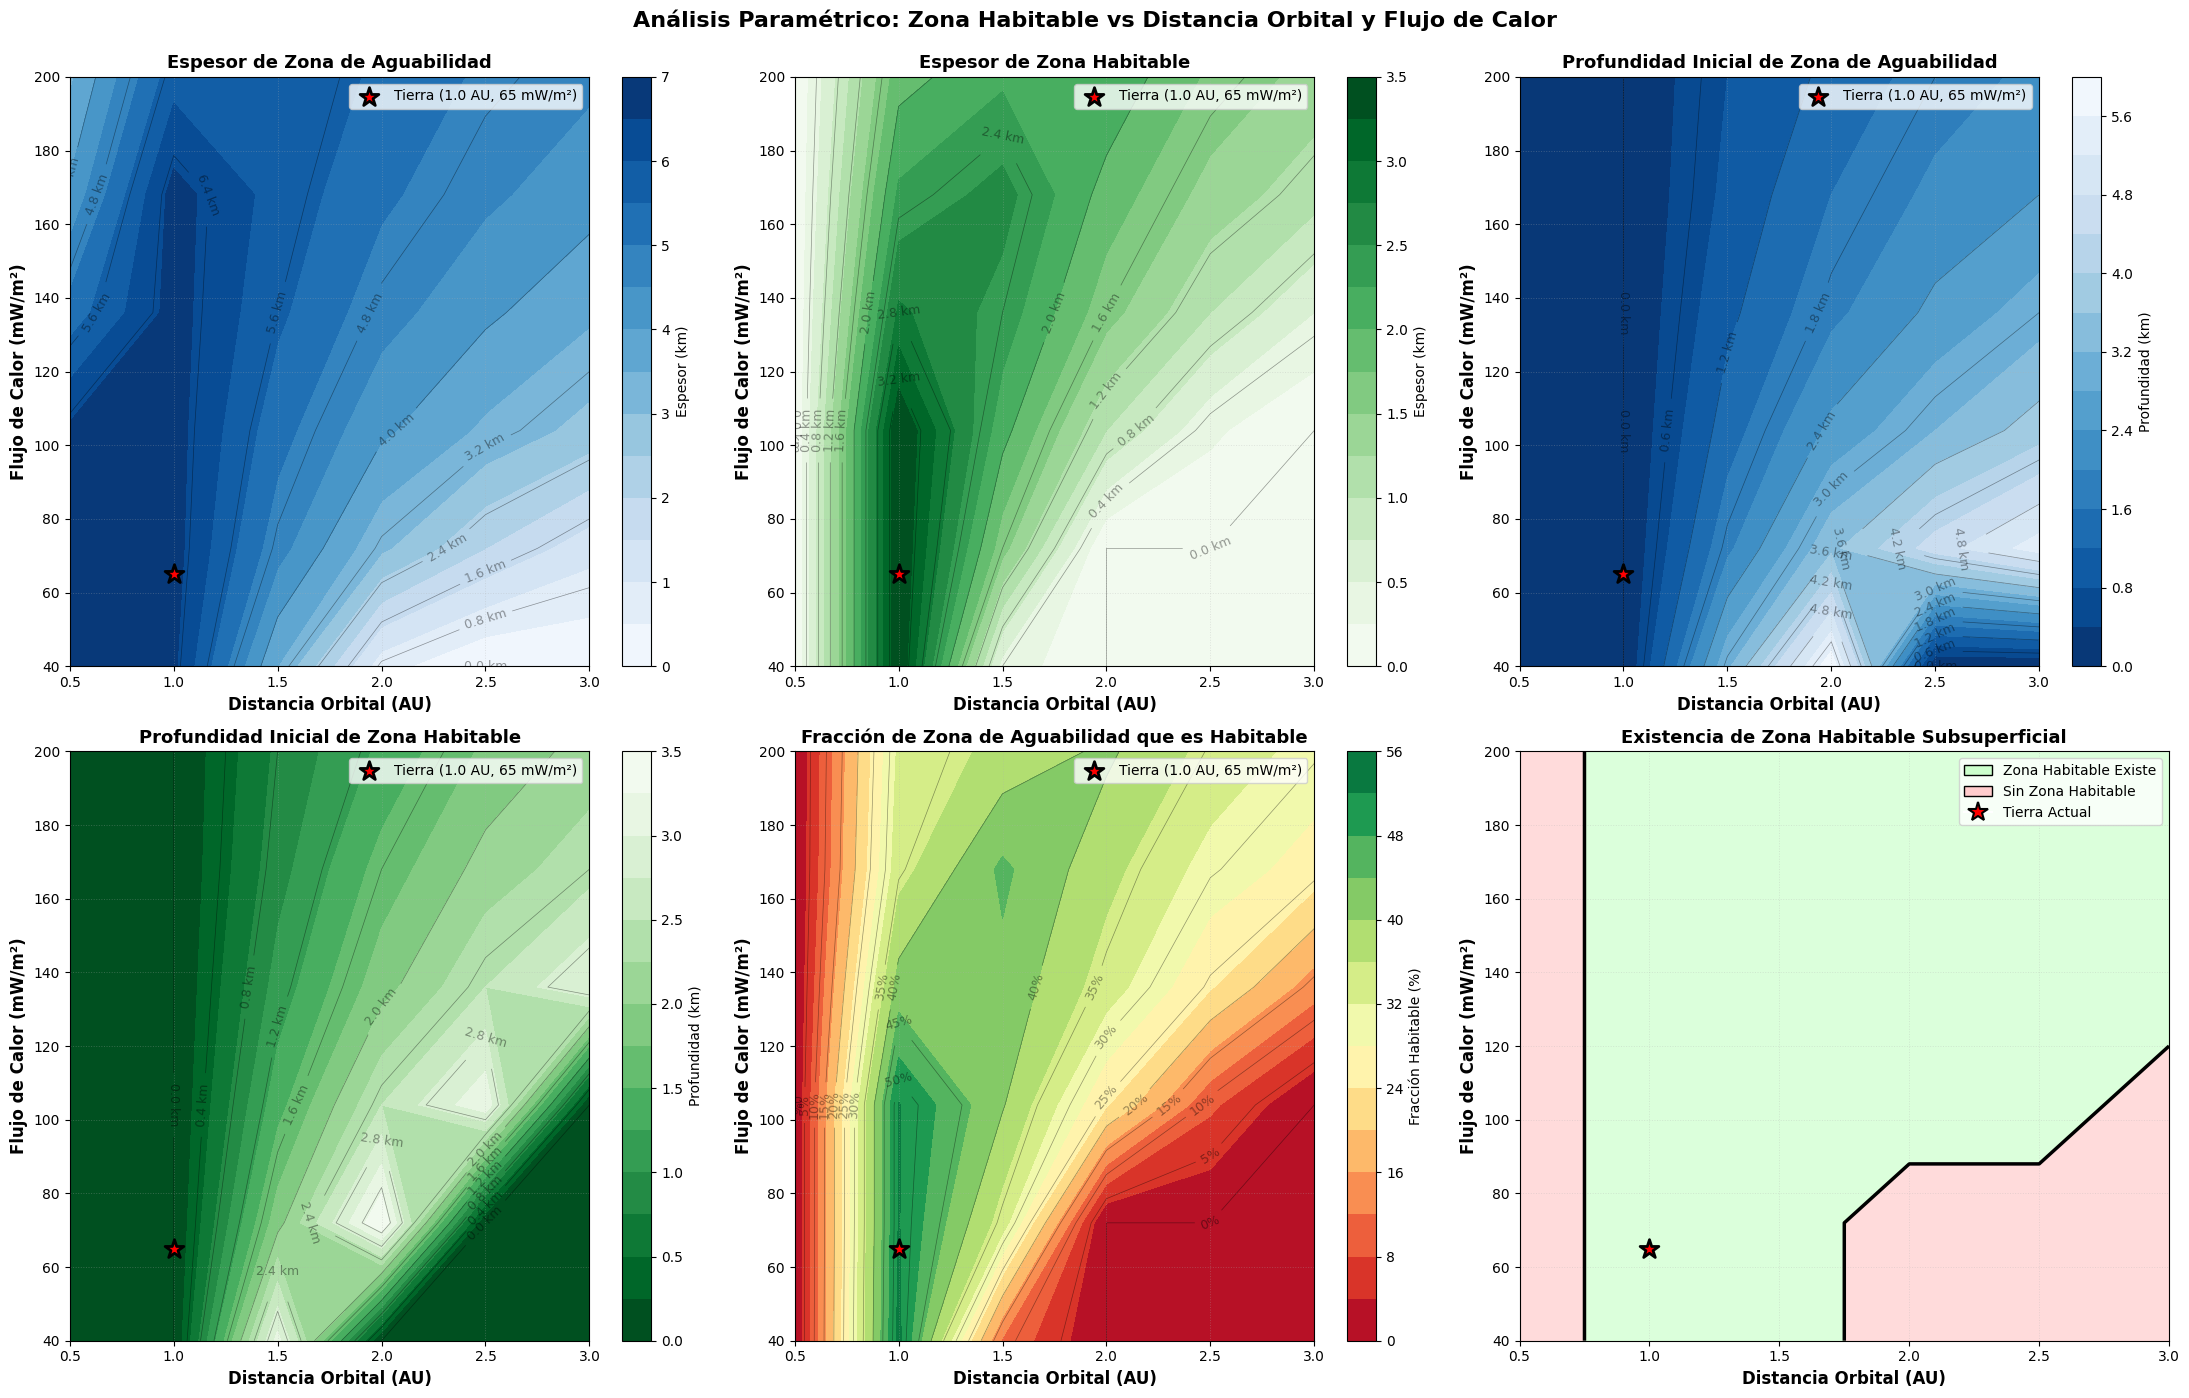


RESUMEN ESTADÍSTICO: ANÁLISIS PARAMÉTRICO

📊 ZONA DE AGUABILIDAD:
   Espesor máximo: 6.70 km
   En: d = 1.00 AU, q = 72 mW/m²
   Espesor mínimo (excluyendo cero): 0.70 km

🦠 ZONA HABITABLE:
   Espesor máximo: 3.50 km
   En: d = 1.00 AU, q = 40 mW/m²
   Número de escenarios con zona habitable: 23/36
   Porcentaje de escenarios habitables: 63.9%

📈 FRACCIÓN HABITABLE:
   Máxima: 53.0%
   En: d = 1.00 AU, q = 40 mW/m²
   Promedio (donde existe habitabilidad): 34.0%

🌍 VALORES PARA LA TIERRA (1.0 AU, 65 mW/m²):
   Zona de Aguabilidad: 6.70 km
   Zona Habitable: 3.50 km
   Fracción Habitable: 52.2%
   Profundidad inicial agua: 0.00 km
   Profundidad inicial habitable: 0.00 km


In [45]:
data_grid = habitability_vs_distance_heatflux(max_distance=3.0,
                                               max_heatflux=200e-3)

plots_habitability_contours(data_grid)

## Zona de Habitabilidad según Kopparapu et al. (2013)

Visualización de los límites conservadores y optimistas de la zona de habitabilidad para una estrella tipo Sol, basado en el modelo radiativo-convectivo 1D de Kopparapu et al. (2013) ApJ 765:131.

**Límites conservadores**:
- **Moist Greenhouse** (interno): Límite donde la estratosfera se satura de vapor de agua
- **Maximum Greenhouse** (externo): Máximo efecto invernadero con CO₂

**Límites optimistas**:
- **Recent Venus** (interno): Basado en evidencias de agua líquida en Venus temprano (~1 Ga)
- **Early Mars** (externo): Basado en evidencias de agua líquida en Marte primitivo (~3.8 Ga)

In [ ]:
# ============================================================================
# ZONA DE HABITABILIDAD - Kopparapu et al. (2013)
# ============================================================================

# Constantes
AU = const.au.value  # 1 Unidad Astronómica en metros
L_sun = const.L_sun.value  # Luminosidad del Sol en W

# Coeficientes de Kopparapu et al. (2013) - Tabla 3
# Para cada límite: S_eff = S_eff_sun + a*dT + b*dT^2 + c*dT^3 + d*dT^4
# donde dT = T_eff - 5780 K

hz_limits = {
    # Límites CONSERVADORES
    'Recent Venus': {
        'S_eff_sun': 1.7763,
        'a': 1.4335e-4,
        'b': 3.3954e-9,
        'c': -7.6364e-12,
        'd': -1.1950e-15,
        'type': 'optimista',
        'boundary': 'interno'
    },
    'Runaway Greenhouse': {
        'S_eff_sun': 1.0385,
        'a': 1.2456e-4,
        'b': 1.4612e-8,
        'c': -7.6345e-12,
        'd': -1.7511e-15,
        'type': 'conservador',
        'boundary': 'interno'
    },
    'Moist Greenhouse': {
        'S_eff_sun': 1.0146,
        'a': 8.1884e-5,
        'b': 1.9394e-9,
        'c': -4.3618e-12,
        'd': -6.8260e-16,
        'type': 'conservador',
        'boundary': 'interno'
    },
    'Maximum Greenhouse': {
        'S_eff_sun': 0.3507,
        'a': 5.9578e-5,
        'b': 1.6707e-9,
        'c': -3.0058e-12,
        'd': -5.1925e-16,
        'type': 'conservador',
        'boundary': 'externo'
    },
    'Early Mars': {
        'S_eff_sun': 0.3207,
        'a': 5.4471e-5,
        'b': 1.5275e-9,
        'c': -2.1709e-12,
        'd': -3.8282e-16,
        'type': 'optimista',
        'boundary': 'externo'
    }
}


def hz_distance(T_eff, L_star, limit_name):
    """
    Calcula la distancia de un límite de la ZH según Kopparapu 2013.
    
    Parameters
    ----------
    T_eff : float
        Temperatura efectiva de la estrella (K)
    L_star : float
        Luminosidad de la estrella (W)
    limit_name : str
        Nombre del límite (clave en hz_limits)
        
    Returns
    -------
    float
        Distancia orbital en UA
    """
    params = hz_limits[limit_name]
    dT = T_eff - 5780.0  # Diferencia con el Sol
    
    # Calcular S_eff
    S_eff = (params['S_eff_sun'] + 
             params['a'] * dT + 
             params['b'] * dT**2 + 
             params['c'] * dT**3 + 
             params['d'] * dT**4)
    
    # Distancia en AU: d = sqrt(L/L_sun / S_eff)
    d_AU = np.sqrt((L_star / L_sun) / S_eff)
    
    return d_AU


# Parámetros del Sol
T_eff_sun = 5780.0  # K
L_star_sun = L_sun  # W

# Calcular distancias de los límites para el Sol
distances_kopparapu = {}
for limit_name in hz_limits:
    distances_kopparapu[limit_name] = hz_distance(T_eff_sun, L_star_sun, limit_name)

print("="*70)
print("ZONA DE HABITABILIDAD - Sol (Kopparapu et al. 2013)")
print("="*70)
print(f"\nParámetros estelares:")
print(f"  T_eff = {T_eff_sun} K")
print(f"  L = {L_star_sun/L_sun:.2f} L_sun")
print(f"\nLímites CONSERVADORES:")
print(f"  Moist Greenhouse (interno):  {distances_kopparapu['Moist Greenhouse']:.4f} AU")
print(f"  Runaway Greenhouse (interno): {distances_kopparapu['Runaway Greenhouse']:.4f} AU")
print(f"  Maximum Greenhouse (externo): {distances_kopparapu['Maximum Greenhouse']:.4f} AU")
print(f"\nLímites OPTIMISTAS:")
print(f"  Recent Venus (interno):       {distances_kopparapu['Recent Venus']:.4f} AU")
print(f"  Early Mars (externo):         {distances_kopparapu['Early Mars']:.4f} AU")
print(f"\nZona Habitable Conservadora:  {distances_kopparapu['Moist Greenhouse']:.4f} - {distances_kopparapu['Maximum Greenhouse']:.4f} AU")
print(f"Zona Habitable Optimista:     {distances_kopparapu['Recent Venus']:.4f} - {distances_kopparapu['Early Mars']:.4f} AU")
print("="*70)


ZONA DE HABITABILIDAD - Sol (Kopparapu et al. 2013)

Parámetros estelares:
  T_eff = 5780.0 K
  L = 1.00 L_sun

Límites CONSERVADORES:
  Moist Greenhouse (interno):  0.9928 AU
  Runaway Greenhouse (interno): 0.9813 AU
  Maximum Greenhouse (externo): 1.6886 AU

Límites OPTIMISTAS:
  Recent Venus (interno):       0.7503 AU
  Early Mars (externo):         1.7658 AU

Zona Habitable Conservadora:  0.9928 - 1.6886 AU
Zona Habitable Optimista:     0.7503 - 1.7658 AU


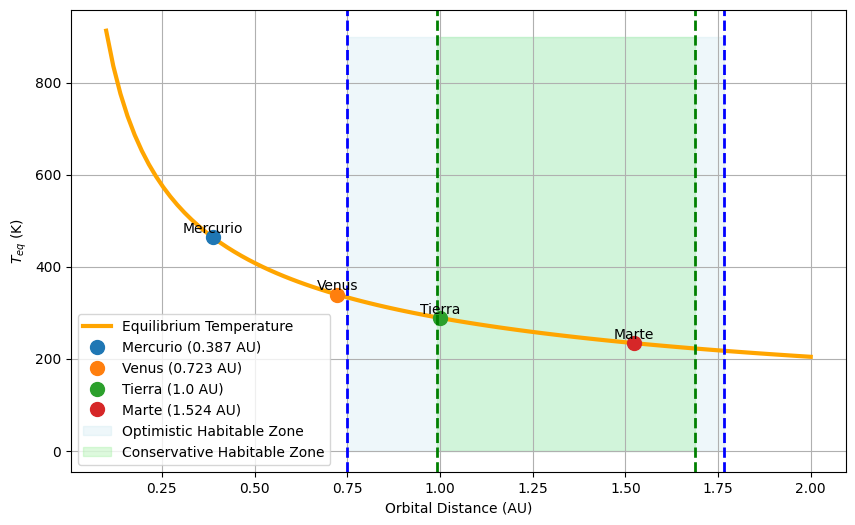

In [86]:
ds = np.linspace(0.1, 2.0, 100)
T_eqs = [T_eq(distance_AU=d) for d in ds]

planets = {
    'Mercurio': 0.387,
    'Venus': 0.723,
    'Tierra': 1.000,
    'Marte': 1.524,
}

plt.figure(figsize=(10, 6))
plt.plot(ds, T_eqs, 'orange', linewidth=3, label='Equilibrium Temperature')
for planet, d in planets.items():
    T_eq_planet = T_eq(distance_AU=d)
    plt.plot(d, T_eq_planet, 'o', markersize=10, label=f'{planet} ({d} AU)')
    plt.text(d, T_eq_planet + 10, planet, fontsize=10, ha='center')
plt.axvline(distances_kopparapu['Moist Greenhouse'], color='green', linestyle='--', linewidth=2)
plt.axvline(distances_kopparapu['Maximum Greenhouse'], color='green', linestyle='--', linewidth=2)

plt.axvline(distances_kopparapu['Recent Venus'], color='blue', linestyle='--', linewidth=2)
plt.axvline(distances_kopparapu['Early Mars'], color='blue', linestyle='--', linewidth=2)
plt.fill_betweenx([0, 900], distances_kopparapu['Recent Venus'], distances_kopparapu['Early Mars'], 
                 color='lightblue', alpha=0.2, label='Optimistic Habitable Zone')
plt.fill_betweenx([0, 900], distances_kopparapu['Moist Greenhouse'], distances_kopparapu['Maximum Greenhouse'], 
                 color='lightgreen', alpha=0.3, label='Conservative Habitable Zone')

plt.xlabel('Orbital Distance (AU)')
plt.ylabel('$T_{eq}$ (K)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Santiago\AppData\Local\Temp\ipykernel_23076\1714727290.py:95: RuntimeWarning: invalid value encountered in divide
  (habitable_thickness_grid.T / water_thickness_grid.T) * 100,


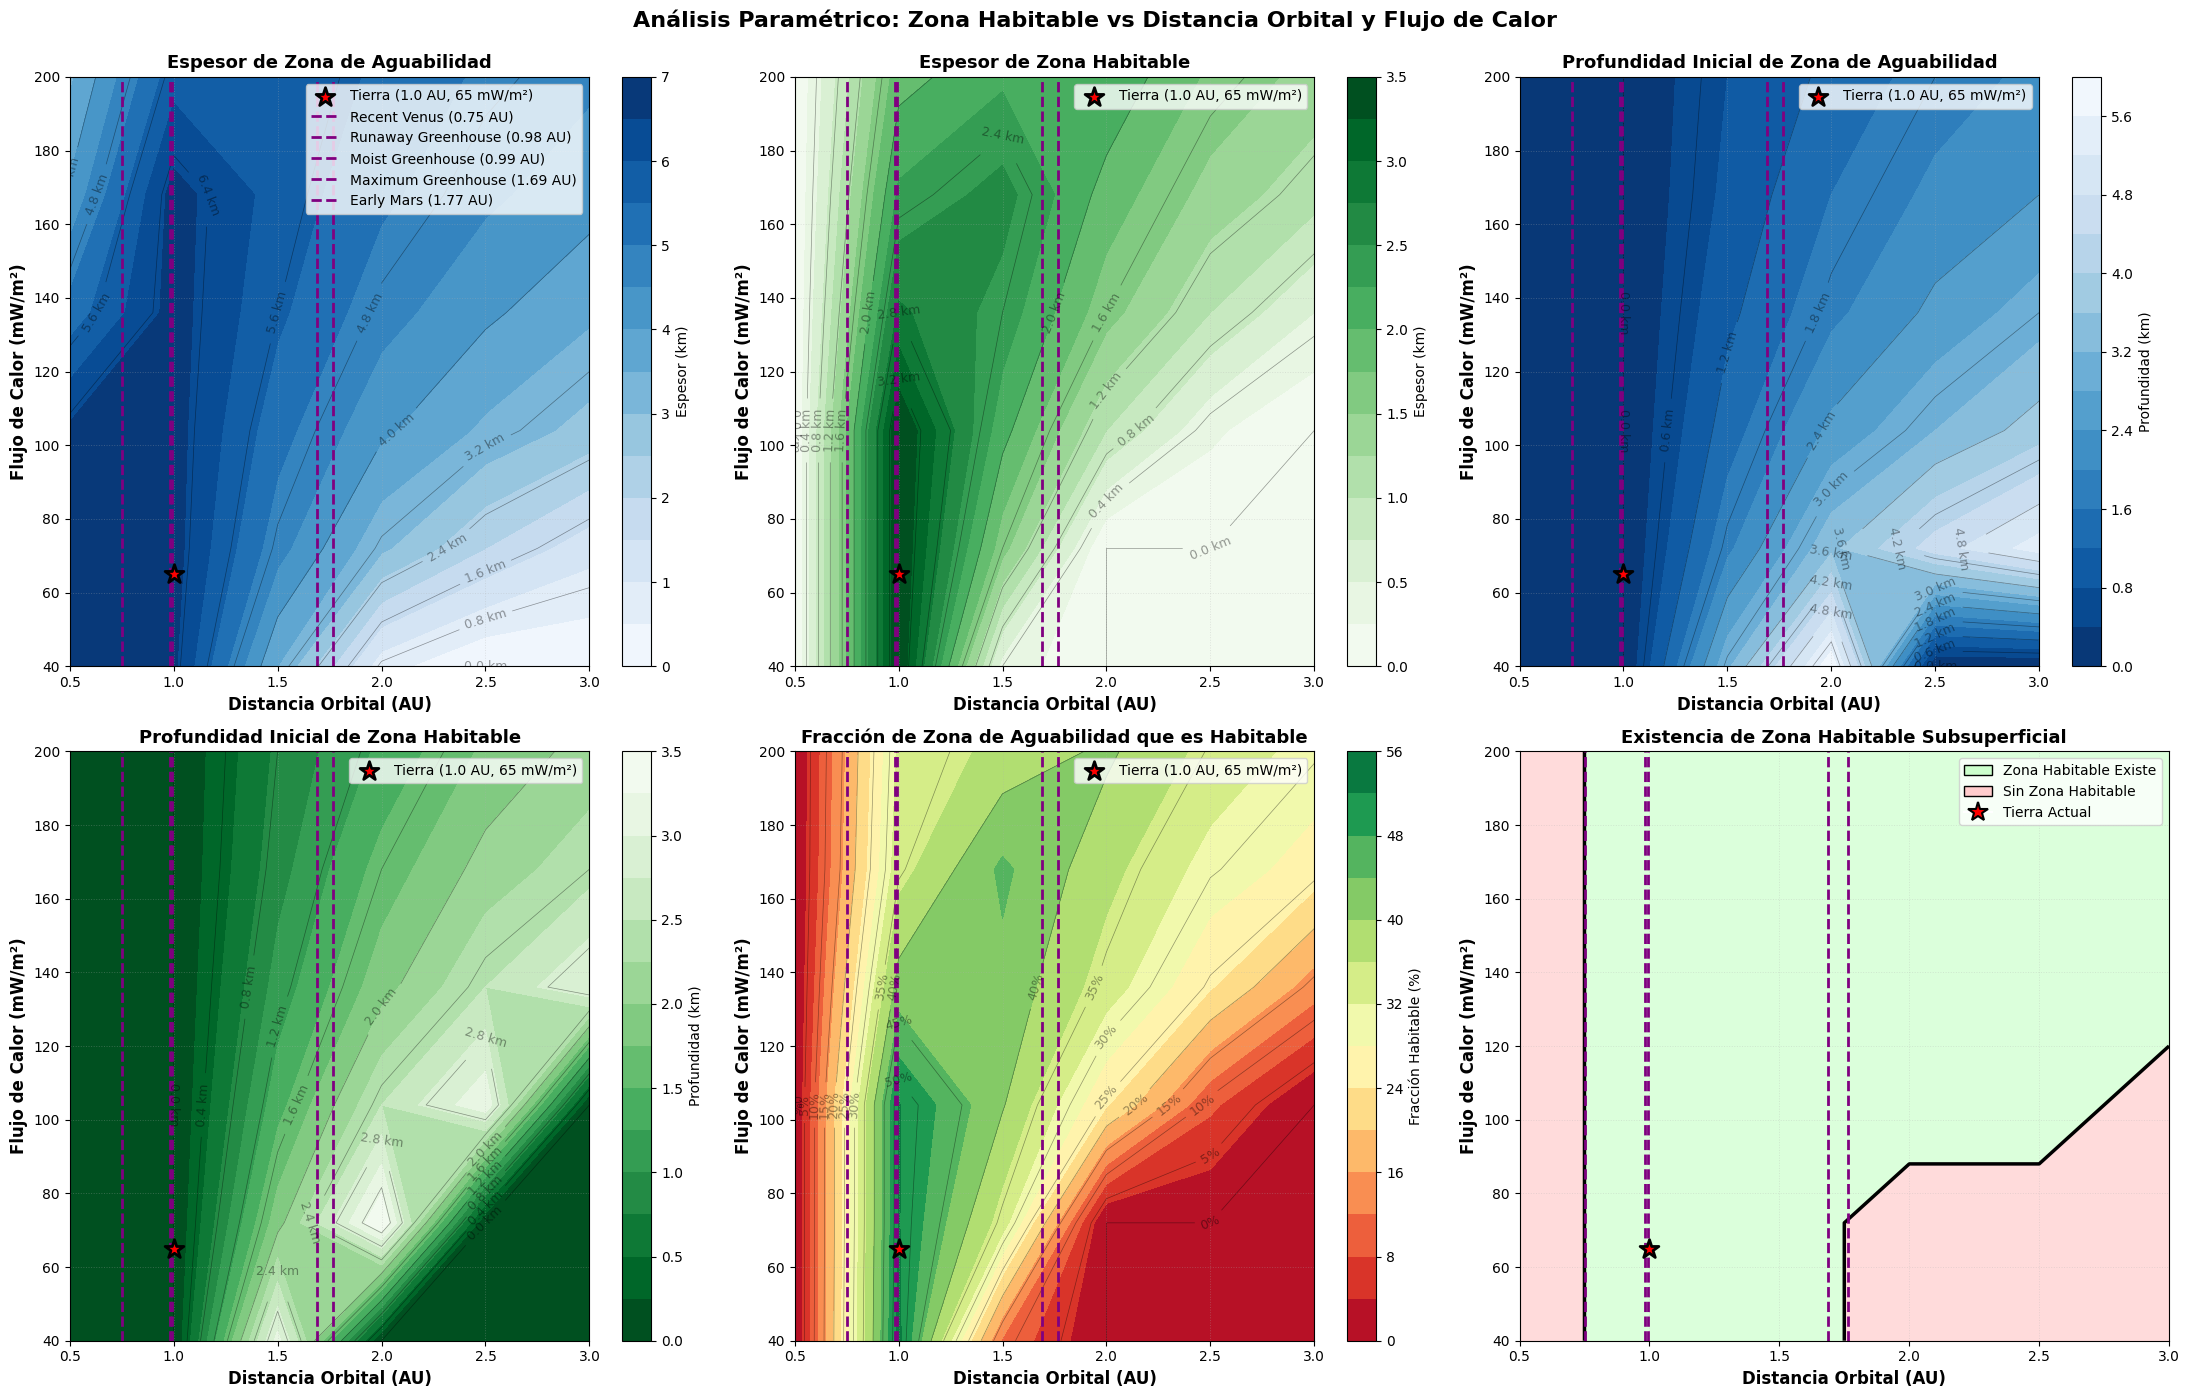


RESUMEN ESTADÍSTICO: ANÁLISIS PARAMÉTRICO

📊 ZONA DE AGUABILIDAD:
   Espesor máximo: 6.70 km
   En: d = 1.00 AU, q = 72 mW/m²
   Espesor mínimo (excluyendo cero): 0.70 km

🦠 ZONA HABITABLE:
   Espesor máximo: 3.50 km
   En: d = 1.00 AU, q = 40 mW/m²
   Número de escenarios con zona habitable: 23/36
   Porcentaje de escenarios habitables: 63.9%

📈 FRACCIÓN HABITABLE:
   Máxima: 53.0%
   En: d = 1.00 AU, q = 40 mW/m²
   Promedio (donde existe habitabilidad): 34.0%

🌍 VALORES PARA LA TIERRA (1.0 AU, 65 mW/m²):
   Zona de Aguabilidad: 6.70 km
   Zona Habitable: 3.50 km
   Fracción Habitable: 52.2%
   Profundidad inicial agua: 0.00 km
   Profundidad inicial habitable: 0.00 km


In [87]:
plots_habitability_contours(data_grid, kopparapu_limits=distances_kopparapu)